In [104]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import Modules

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np
from scipy.stats import loggamma
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import os
# switch to the appropriate directory for running the code
if os.getcwd()[-16:] != 'debiased-vb-mlmc':
    os.chdir("../")
    assert os.getcwd()[-16:] == 'debiased-vb-mlmc'

In [4]:
import src.utils.utils as utils
from src.models.LDA.onlinelda import *
from src.models.LDA.onlinelda_debiased import *

# Load Dataset

In [5]:
# The number of documents to analyze each iteration
batchsize = 64
# The number of topics
K = 100

In [6]:
# load dictionary of vocabulary
vocab = open('./data/dictionary.txt').read().splitlines()
vocab = {w:i for i,w in enumerate(vocab)}

In [7]:
# loading wikipedia dataset for the first time can take a long time
# because it downloads the dataset of about 16GB
wiki_train, wiki_info = \
    tfds.load(name="wikipedia/20190301.en", data_dir="./data", split="train", batch_size=batchsize, with_info=True)

In [8]:
# The total number of documents in Wikipedia
D = wiki_info.splits["train"].num_examples
# The number of vocabulary
V = len(vocab)

# Run online LDA

In [171]:
# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
lda = olda.OnlineLDA(vocab, K, D, 1./K, 1./K, 1024., 0.7)   

In [174]:
logs_tmp = []
logs = pd.DataFrame(columns=[
    "per_word_ELBO"#, "per_word_LMELBO1", "per_word_LMELBO4", "per_word_LMELBO16", "per_word_LMELBO64"
])
timestamp = utils.timestamp()
os.makedirs("./out/LDA/{}".format(timestamp))

for i, wiki_example in enumerate(wiki_train):
    
    docs = wiki_example['text'].numpy()
    wordids, wordcts = utils.parse_docs(docs, vocab)
    
    gamma = lda.update_lambda(wordids, wordcts)
    
    log = {}
    log['per_word_ELBO'] = lda.approx_ELBO(wordids, wordcts, gamma) * batchsize / (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO1'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=1) * batchsize / (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO4'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=4) * batchsize / (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO16'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=16) * batchsize / (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO64'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=64) * batchsize / (D * sum(map(sum, wordcts)))
    
    logs_tmp.append(log)
    
    if i%1e+2==0:
        # Compute an estimate of per-word ELBO
        print("{}:  rho_t = {},  per-word ELBO estimate = {}".format(i, lda._rhot, log['per_word_ELBO']))
        np.savetxt("./out/LDA/{}/lambda-{}.dat".format(timestamp, i), lda._lambda)
        logs = logs.append(pd.DataFrame(logs_tmp))
        logs.to_csv("./out/LDA/{}/logs.csv".format(timestamp))
        logs_tmp = []
    if i==1e+4:
        break

0:  rho_t = 0.007807163853030824,  per-word ELBO estimate = -5.951007527693849
100:  rho_t = 0.007314644677114575,  per-word ELBO estimate = -7.623888995862994
200:  rho_t = 0.006891356828814637,  per-word ELBO estimate = -7.5072869109089595
300:  rho_t = 0.006523022630113248,  per-word ELBO estimate = -7.372506905093526
400:  rho_t = 0.00619911360001217,  per-word ELBO estimate = -7.485013759725349
500:  rho_t = 0.005911682611018344,  per-word ELBO estimate = -7.3388302522252316
600:  rho_t = 0.005654609835874037,  per-word ELBO estimate = -7.111159861578294
700:  rho_t = 0.0054231002206634165,  per-word ELBO estimate = -7.486687811242188
800:  rho_t = 0.005213339309492677,  per-word ELBO estimate = -7.19860320122002
900:  rho_t = 0.00502225183722324,  per-word ELBO estimate = -7.343997769450668
1000:  rho_t = 0.0048473288143795375,  per-word ELBO estimate = -7.220213504990467
1100:  rho_t = 0.00468650134421386,  per-word ELBO estimate = -7.325148463498646
1200:  rho_t = 0.00453804699

10000:  rho_t = 0.001480249698520261,  per-word ELBO estimate = -7.140198557221258


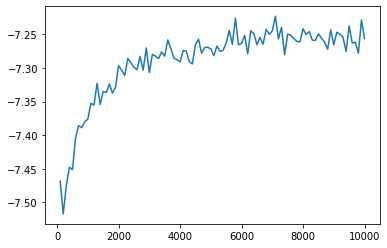

In [175]:
x = logs.values[:10000]
plt.plot(100*np.arange(100) + 100, x.reshape([-1,100]).mean(axis=1))

In [155]:
# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
lda = OnlineLDA_deviased(vocab, K, D, 1./K, 1./K, 1024., 0.7)   

In [156]:
logs_tmp = []
logs = pd.DataFrame(columns=[
    "per_word_ELBO"#, "per_word_LMELBO1", "per_word_LMELBO4", "per_word_LMELBO16", "per_word_LMELBO64"
])
timestamp = utils.timestamp()
os.makedirs("./out/LDA/{}".format(timestamp))

for i, wiki_example in enumerate(wiki_train):
    
    docs = wiki_example['text'].numpy()
    wordids, wordcts = utils.parse_docs(docs, vocab)    
    batchD= len(wordids) # This can be less than batchsize
    ELBO = lda.update("ELBO")
    
    log = {}
    log['per_word_ELBO'] = ELBO.numpy() * batchD / (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO1'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=1) * batchD/ (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO4'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=4) * batchD/ (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO16'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=16) * batchD/ (D * sum(map(sum, wordcts)))
    #log['per_word_LMELBO64'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=64) * batchD/ (D * sum(map(sum, wordcts)))
    
    logs_tmp.append(log)
    
    if i%1000==0:
        # Compute an estimate of per-word ELBO
        print("{}:  rho_t = {},  per-word ELBO estimate = {},  alpha = {},  eta = {}".format(i, lda._rhot, log['per_word_ELBO'], lda._alpha, lda._eta))
        np.savetxt("./out/LDA/{}/lambda-{}.dat".format(timestamp, i), lda._lambda)
        logs = logs.append(pd.DataFrame(logs_tmp), ignore_index=True)
        logs.to_csv("./out/LDA/{}/logs.csv".format(timestamp))
        logs_tmp = []
    if i==1e+4:
        break

0:  rho_t = 0.007807163853030824,  per-word ELBO estimate = -5.913213714580314,  alpha = 0.009758348128384416,  eta = 0.010768066864992116
1000:  rho_t = 0.0048473288143795375,  per-word ELBO estimate = -7.155955787620383,  alpha = 0.06948019462484795,  eta = 0.08589335157067406
2000:  rho_t = 0.0036600939616169533,  per-word ELBO estimate = -7.263458089093254,  alpha = 0.06687325844689138,  eta = 0.05708861077150293
3000:  rho_t = 0.0029968422353315676,  per-word ELBO estimate = -6.558426046622242,  alpha = 0.0637060367381796,  eta = 0.04405468784056371
4000:  rho_t = 0.0025656933806527224,  per-word ELBO estimate = -7.252034218969322,  alpha = 0.06418354928919855,  eta = 0.036763368341818266
5000:  rho_t = 0.0022595921855528963,  per-word ELBO estimate = -7.295181283672986,  alpha = 0.06443137433892578,  eta = 0.03206149039383092
6000:  rho_t = 0.0020293061427815464,  per-word ELBO estimate = -7.190427633952557,  alpha = 0.061676070637397225,  eta = 0.02878446247671792
7000:  rho_t =

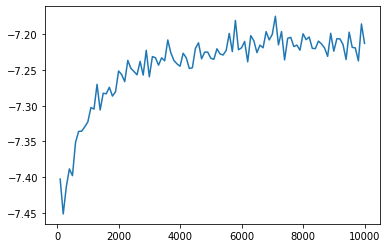

In [170]:
x = logs.values[:10000]
plt.plot(100*np.arange(100) + 100, x.reshape([-1,100]).mean(axis=1))

# Dev

In [9]:
from scipy.special import gammaln, psi, polygamma
digamma = psi
trigamma = lambda x:polygamma(n=1, x=x)

In [10]:
tf_float_type = tf.float64
np_float_type = np.float64
as_tf_float = lambda x: tf.cast(x, tf_float_type)
tf_gammaln = tf.math.lgamma
tf_digamma = tf.math.digamma
softplus = lambda x: x + np.log(1 + np.exp(-x))
softplus_inv = lambda x: x + np.log(1 - np.exp(-x))
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [11]:
# for numerical stability
# apply log(sum(exp(x))) or log(mean(exp(x))) along the selected axis 
def logsumexp(ary, axis=1, keepdims=False):
    # for numerical stability
    _max = ary.max(axis=axis, keepdims=True)
    out = np.log( np.sum( np.exp(ary - _max) ,axis=axis, keepdims=keepdims) ) + _max
    if keepdims==False:
        return out.squeeze(axis=axis)
    elif keepdims==True:
        return out
    else:
        print("keepdims must be bool. Returning None")
        return None

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

In [12]:
def dirichlet_natgrad(alpha, dy_dalpha, K=None):
    '''
    Compute natural gradient of alpha for dirichlet distribution
    
    Argument:
    alpha: Matrix (stacked vectors) representing parameters of n_param dirichlet distributions, 
    whose shape is [n_param, n_dim] (or [1] when the dirichlet parameters are the same for each component).
    dy_dalpha: Matrix (stacked vectors) representing the gradient with respect to the parameters, 
    whose shape is [n_param, n_dim] (or [1] when the dirichlet parameters are the same for each component).

    Returns:
    natgrad: Natural gradient of the parameters of the dirichlet distributions.
    '''
    if type(alpha)==np.ndarray:
        trigamma_alpha = trigamma(alpha) # shape: [n_param, n_dim]
        trigamma_alpha0 = trigamma(np.sum(alpha, axis=1, keepdims=True)) # shape: [n_param, 1]
        natgrad = 0 # of shape [n_param, n_dim]
        natgrad += trigamma_alpha**(-1) * dy_dalpha
        natgrad += trigamma_alpha**(-1)\
                * np.sum(trigamma_alpha**(-1) * dy_dalpha, axis=1, keepdims=True)\
                / (trigamma_alpha0**(-1) - np.sum(trigamma_alpha**(-1), axis=1, keepdims=True))
        return natgrad

    else:
        # when the dirichlet parameters are the same for each component
        assert type(alpha)==np_float_type
        cov = K*trigamma(alpha) - K**2 * trigamma(K*alpha)
        return dy_dalpha / cov

In [13]:
def dirichlet_KL(alpha, beta):
    '''
    Compute the KL divergence between Dir(alpha_i) and Dir(beta_i) for i = 1,..., n_param.
    
    Arguments:
    alpha: array of shape [n_param, n_dim]
    beta: array of shape [n_param, n_dim]
    
    Returns:
    KL: sum of KL divergences
    '''
    KL = 0 # of shape [n_param]
    KL += gammaln(alpha.sum(axis=1)) - gammaln(alpha).sum(axis=1)
    KL += -gammaln(beta.sum(axis=1)) + gammaln(beta).sum(axis=1) 
    KL += ((alpha - beta) * (digamma(alpha) - digamma(alpha.sum(axis=1, keepdims=True)))).sum(axis=1)
    return sum(KL)


In [14]:
def tf_dirichlet_expectation(alpha):
    """
    For a vector theta ~ Dir(alpha), compute E[log(theta)] given alpha.
    
    Arguments:
    alpha: Tensor of parameters of n_params different dirichlet distributions whose shape is:[n_params, n_dim] or [n_dim]. 


    Returns:
    : Expectation of log of samples from the dirichlet distributions
    """
    assert len(alpha.shape)<=2
    if (len(alpha.shape) == 1):
        return tf_digamma(alpha) - tf_digamma(tf.reduce_sum(alpha, keepdims=True))
    return tf_digamma(alpha) - tf_digamma(tf.reduce_sum(alpha, axis=1, keepdims=True))


In [15]:
def dirichlet_sample(alpha, n_MC):
    """
    Sample log of dirichlet distribution, whose dimetion is n_dim.
    We sample from n_params diferrent parameter settings, for n_MC times each.
    Here, we sample the logarithm value for the sake of numerical stability.
    
    Arguments:
    alpha: Tensor of parameters of n_params different dirichlet distributions whose shape is:[n_params, n_dim] or [n_dim]. 
    n_MC: the # of Monte Carlo sample
    
    Returns: 
    log_dir: Tensor of log of MC-samples log(theta) for theta ~ Dir(alpha). The shape of this tensor is [n_MC, n_params, n_dim].
    """
    
    # make sure that dim(ary)<=2
    assert len(alpha.shape)<=2
    # handle cases where n_params = 1
    flag = (len(alpha.shape)==1)
    if flag==True:
        alpha = np.expand_dims(alpha, axis=0)
        
    (n_params, n_dim) = alpha.shape
    # for the sampling scheme of log of gamma distributions below, 
    # see https://stats.stackexchange.com/questions/7969/how-to-quickly-sample-x-if-expx-gamma  
    log_u = np.log(np.random.uniform(size=[n_MC, n_params, n_dim]))
    log_gammas = loggamma.rvs(c=alpha+1, size=[n_MC, n_params, n_dim]) + log_u / np.expand_dims(alpha, axis=0)
    log_dir = log_gammas - logsumexp(log_gammas, axis=2, keepdims=True)
    
    # handle cases where n_params = 1
    if flag==True:
        log_dir = log_dir.reshape([n_MC, n_dim]) 
    
    return log_dir


In [16]:
def tf_dirichlet_sample(alpha, n_MC):
    """
    Sample log of dirichlet distribution, whose dimetion is n_dim.
    We sample from n_params diferrent parameter settings, for n_MC times each.
    Here, we sample the logarithm value for the sake of numerical stability.
    
    Arguments:
    alpha: Tensor of parameters of n_params different dirichlet distributions whose shape is:[n_params, n_dim] or [n_dim]. 
    n_MC: the # of Monte Carlo sample
    
    Returns: 
    log_dir: Tensor of log of MC-samples log(theta) for theta ~ Dir(alpha). The shape of this tensor is [n_MC, n_params, n_dim].
    """
    
    # make sure that dim(ary)<=2
    assert len(alpha.shape)<=2
    # handle cases where n_params = 1
    flag = (len(alpha.shape)==1)
    if flag==True:
        alpha = tf.expand_dims(alpha, axis=0)
        
    (n_params, n_dim) = alpha.shape
    # for the sampling scheme of log of gamma distributions below, 
    # see https://stats.stackexchange.com/questions/7969/how-to-quickly-sample-x-if-expx-gamma  
    log_u = tf.math.log(tf.random.uniform(shape=[n_MC, n_params, n_dim], dtype=tf_float_type))
    log_gammas = tf.math.log(tf.random.gamma(alpha=alpha+1, shape=[n_MC], dtype=tf_float_type)) + log_u / tf.expand_dims(alpha, axis=0)
    log_dir = log_gammas - tf_logsumexp(log_gammas, axis=2, keepdims=True)
    
    # handle cases where n_params = 1
    if flag==True:
        log_dir = tf.reshape(log_dir, [n_MC, n_dim]) 
    
    return log_dir


In [59]:
class OnlineLDA_deviased(olda.OnlineLDA):
    
    def update_param(self, wordids, wordcts, objective="ELBO"):
        """
        
        """ 
    
        assert len(wordids)>0
    
        gamma = lda.update_lambda(wordids, wordcts)
        
        with tf.GradientTape() as g:
            alpha = tf.Variable(self._alpha)
            eta = tf.Variable(self._eta)
            
            if objective=="ELBO":
                score = self._approx_ELBO(wordids, wordcts, gamma, alpha, eta, self._lambda)
            elif objective[:6]=="LMELBO": # ex. "LMELBO16" 
                n_MC = int(objective[6:])
                score = self._approx_LMELBO(wordids, wordcts, gamma, alpha, eta, self._lambda, n_MC)
            else:
                print("Unknown objective givein to grad_update. Returning None.")
                return None

        dy_dalpha, dy_deta = [dy.numpy() for dy in g.gradient(score, [alpha, eta])]

        alpha_tilde = softplus_inv(self._alpha)
        eta_tilde = softplus_inv(self._eta)

        alpha_tilde += self._rhot*0.00005 * (1 / sigmoid(alpha_tilde)) * dirichlet_natgrad(self._alpha, dy_dalpha, self._K)
        eta_tilde += self._rhot*0.1 * (1 / sigmoid(eta_tilde)) * dirichlet_natgrad(self._eta, dy_deta, self._V)

        self._alpha = softplus(alpha_tilde)
        self._eta = softplus(eta_tilde)

        return gamma, score.numpy()
    
    def _approx_ELBO(self, wordids, wordcts, gamma, alpha, eta, lambd):
        """
        Estimates the lower bound of log p(w) over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """
        batchD = len(wordids)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        Elogbeta = tf_dirichlet_expectation(lambd)

        # E_q[log p(x, z| theta, beta) - log q(z)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = wordids[d]
            cts = np.array(wordcts[d])
            temp = Elogtheta[d, :].reshape([-1,1]) + tf.gather(Elogbeta, ids, axis=1)
            phinorm = tf_logsumexp(temp, 0) 
            score += tf.reduce_sum(cts * phinorm)
            
        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += tf.reduce_sum((alpha - gamma)*Elogtheta)
        score += tf.reduce_sum(gammaln(gamma) - tf_gammaln(alpha))
        score += tf.reduce_sum(tf_gammaln(alpha*self._K) - gammaln(np.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * self._D / batchD
    
        # E[log p(beta | eta) - log q (beta | lambda)]
        score += tf.reduce_sum((eta-lambd)*Elogbeta)
        score += tf.reduce_sum(tf_gammaln(lambd) - tf_gammaln(eta)) \
                 + tf.reduce_sum(tf_gammaln(eta*self._V) - tf_gammaln(tf.reduce_sum(lambd, 1, keepdims=True)))
        
        return(score)
    
    def approx_ELBO(self, wordids, wordcts, gamma):
        return self._approx_ELBO(wordids, wordcts, gamma, self._alpha, self._eta, self._lambda).numpy()

    def _approx_local_logL(self, ids, cts, gammad, alpha, log_thetas, log_beta):
        """
        Estimates E_q[log p(x_d|beta)] with nested MC for a document x_d. 
        
        Arguments:
        ids: List of word tokens that appearing in the document, which corresponds to wordids[d].
        cts: List of word counts for each token in the document, which corresponds to wordcts[d].
        gammad: Tensor of shape [_K] representing the variational parameters of topic ratio for document, which corresponds to gamma[d,:].
        log_thetas: n_MC MC-samples of topic ratio (log) theta of the document, whose shape is [n_MC, _K].
        log_beta: a MC-sample of vocabulary ratio (log) beta, whose shape is shape [_K, _W].
         
        Returns:
        score: MC estimates of the likelihood of the document.
        """
        log_thetas = tf.expand_dims(log_thetas, axis=2) #shape[n_MC, _K,  1]
        log_beta = tf.expand_dims(log_beta, axis=0)     #shape[   1, _K, _W]
        score = 0
        score += tf.reduce_sum(tf_gammaln(gammad) - tf_gammaln(alpha))
        score += tf_gammaln(alpha*self._K) - tf_gammaln(tf.reduce_sum(gammad))

        temp = 0
        temp += tf.linalg.matvec( tf_logsumexp( log_thetas + tf.gather(log_beta, ids, axis=2), axis=1), cts ) #shape: [n_MC]
        temp += tf.linalg.matvec( log_thetas[:,:,0], alpha - gammad ) #shape: [n_MC]
        score += tf_logmeanexp(temp, axis=0)
        
        return(score)

    def _approx_LMELBO(self, wordids, wordcts, gamma, alpha, eta, lambd, n_MC):
        """
        Estimates the lower bound of log p(w) over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """
        # lower bound of E[log p(x| beta) ]
        batchD = len(wordids)
        score = 0
        
        #shape of betas: [batchD, _K, _W]
        Elogbeta = tf_dirichlet_expectation(lambd)
        log_betas = tf_dirichlet_sample(lambd, n_MC=batchD)
            
        for d in range(0, batchD):
            ids = wordids[d]
            cts = np.array(wordcts[d], dtype=np.float64)
            gammad = gamma[d, :]
            log_thetas = dirichlet_sample(gammad, n_MC=n_MC)
            log_beta = log_betas[d,:,:]
            score += self._approx_local_logL(ids, cts, gammad, alpha, log_thetas, log_beta)
            
        # Compensate for the subsampling of the population of documents
        score = score * self._D / batchD

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + tf.reduce_sum((eta - lambd)*Elogbeta)
        score = score + tf.reduce_sum(tf_gammaln(lambd) - tf_gammaln(eta)) 
        score = score + tf.reduce_sum(tf_gammaln(eta*self._V) - tf_gammaln(tf.reduce_sum(lambd, 1, keepdims=True)))
        
        return(score)

    def approx_LMELBO(self, wordids, wordcts, gamma, n_MC):
        return self._approx_LMELBO(wordids, wordcts, gamma, self._alpha, self._eta, self._lambda, n_MC).numpy()
    
    def _approx_dLMELBO(self, wordids, wordcts, gamma, alpha, eta, lambd, level, verbose=True):
        """
        Estimates the lower bound of log p(w) over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """
        if(level==0):
            if verbose==True:
                print("Using this function at level=0 is not recommended for clarity. \nYou are advised to call OnlineLDA_debiased._approx_LMELBO instead.")
            return self._approx_LMELBO(wordids, wordcts, gamma, alpha, eta, lambd, n_MC=1)
        
        # lower bound of E[log p(x| beta) ]
        batchD = len(wordids)
        score = 0
        
        #shape of betas: [batchD, _K, _W]
        log_betas = tf_dirichlet_sample(lambd, n_MC=batchD)
            
        for d in range(batchD):
            ids = wordids[d]
            cts = np.array(wordcts[d], dtype=np_float_type)
            gammad = gamma[d,:]
            log_thetas = dirichlet_sample(gammad, n_MC=2**level)
            log_beta = log_betas[d,:,:]
            score += (
                self._approx_local_logL(ids, cts, gammad, alpha, log_thetas, log_beta)
                - (1/2.) * self._approx_local_logL(ids, cts, gammad, alpha, log_thetas[:2**(level-1) ,:], log_beta)
                - (1/2.) * self._approx_local_logL(ids, cts, gammad, alpha, log_thetas[ 2**(level-1):,:], log_beta)
                     )  
            # The code fails if (1/2) is used instead of (1/2.). 
            # This is because (1/2)==0 in python2. (In python3, (1/2)==0.5)

        # Compensate for the subsampling of the population of documents
        score = score * self._D / batchD
        return(score)
    
    def approx_dLMELBO(self, wordids, wordcts, gamma, level, verbose=True):
        return self._approx_dLMELBO(wordids, wordcts, gamma, self._alpha, self._eta, self._lambda, level, verbose).numpy()
    
    def _approx_mlmc_LMELBO_bias():
        pass

    def _approx_mlmc_LMELBO(self, wordids, wordcts, gamma, alpha, eta, lambd, start_level, max_level, batchD_start_level):
        # compute locally marginalized elbo using MLMC
        batchD = len(wordids)
        
        # determine costs per level
        levels = np.arange(start_level, max_level+1)
        ave_n_words = float(sum(map(sum, wordcts))) / batchD
        weights = 2**(-3/2.*levels[1:])
        weights /= sum(weights)
        Ns = np.zeros_like(levels)
        Ns[0] = batchD_start_level
        Ns[1:] = np.array([np.math.ceil(w*(batchD - batchD_start_level)) for w in weights], dtype=np.int)
        Ns[1] = batchD - Ns[0] - sum(Ns[2:])
        cumNs = Ns.cumsum()
            
        score = 0
        for i,l in enumerate(levels):
            temp_wordids = wordids[(cumNs[i] - Ns[i]) : (cumNs[i])]
            temp_wordcts = wordcts[(cumNs[i] - Ns[i]) : (cumNs[i])]
            temp_gamma = gamma[(cumNs[i] - Ns[i]) : (cumNs[i]), :]
            if l==start_level:
                score += self._approx_LMELBO(temp_wordids, temp_wordcts, temp_gamma, alpha, eta, lambd, n_MC=2**l)
            else:
                score += self._approx_dLMELBO(temp_wordids, temp_wordcts, temp_gamma, alpha, eta, lambd, level=l)
        
        return score

## Just train the model

In [67]:
# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
lda = OnlineLDA_deviased(vocab, K, D, 1./K, 1./K, 1024., 0.7)   

In [ ]:
logs_tmp = []
logs = pd.DataFrame(columns=[
    "per_word_ELBO", "per_word_LMELBO1", "per_word_LMELBO4", "per_word_LMELBO16", "per_word_LMELBO64"
])
timestamp = utils.timestamp()
os.makedirs("./out/LDA/{}".format(timestamp))

for i, wiki_example in enumerate(wiki_train):
    
    docs = wiki_example['text'].numpy()
    wordids, wordcts = utils.parse_docs(docs, vocab)
    batchD= len(wordids) # This can be less than the batchsize if parser returns [] for any document in the batch
    gamma, score = lda.update_param(wordids, wordcts, "ELBO")
        
    log = {}
    log['alpha'] = lda._alpha
    log['eta'] = lda._eta
    log['per_word_ELBO'] = lda.approx_ELBO(wordids, wordcts, gamma) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO1'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=1) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO4'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=4) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO16'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=16) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO64'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=64) * batchD / (D * sum(map(sum, wordcts)))
    
    logs_tmp.append(log)
    
    if i%1==0:
        # Compute an estimate of per-word ELBO
        print("{}:  rho_t = {:.5f},  per-word ELBO estimate = {:.3f},  per-word LMELBO1 estimate = {:.3f},  alpha = {:.3f},  eta = {:.3f}".format(i, lda._rhot, log['per_word_ELBO'], log['per_word_LMELBO1'], lda._alpha, lda._eta))
    if i%100==0:
        np.savetxt("./out/LDA/{}/lambda-{}.dat".format(timestamp, i), lda._lambda)
        logs = logs.append(pd.DataFrame(logs_tmp), ignore_index=True)
        logs.to_csv("./out/LDA/{}/logs.csv".format(timestamp))
        logs_tmp = []
    if i==1e+4:
        break

0:  rho_t = 0.00781,  per-word ELBO estimate = -5.942,  per-word LMELBO1 estimate = -5.937,  alpha = 0.010,  eta = 0.011
1:  rho_t = 0.00780,  per-word ELBO estimate = -6.598,  per-word LMELBO1 estimate = -6.577,  alpha = 0.010,  eta = 0.012
2:  rho_t = 0.00780,  per-word ELBO estimate = -6.905,  per-word LMELBO1 estimate = -6.876,  alpha = 0.012,  eta = 0.012
3:  rho_t = 0.00779,  per-word ELBO estimate = -7.167,  per-word LMELBO1 estimate = -7.144,  alpha = 0.016,  eta = 0.013
4:  rho_t = 0.00779,  per-word ELBO estimate = -7.201,  per-word LMELBO1 estimate = -7.178,  alpha = 0.019,  eta = 0.014
5:  rho_t = 0.00778,  per-word ELBO estimate = -7.148,  per-word LMELBO1 estimate = -7.119,  alpha = 0.023,  eta = 0.015
6:  rho_t = 0.00778,  per-word ELBO estimate = -5.761,  per-word LMELBO1 estimate = -5.736,  alpha = 0.028,  eta = 0.017
7:  rho_t = 0.00777,  per-word ELBO estimate = -7.403,  per-word LMELBO1 estimate = -7.361,  alpha = 0.031,  eta = 0.018
8:  rho_t = 0.00776,  per-word E

68:  rho_t = 0.00746,  per-word ELBO estimate = -7.417,  per-word LMELBO1 estimate = -7.373,  alpha = 0.106,  eta = 0.156
69:  rho_t = 0.00746,  per-word ELBO estimate = -7.391,  per-word LMELBO1 estimate = -7.332,  alpha = 0.108,  eta = 0.157
70:  rho_t = 0.00745,  per-word ELBO estimate = -7.418,  per-word LMELBO1 estimate = -7.373,  alpha = 0.107,  eta = 0.157
71:  rho_t = 0.00745,  per-word ELBO estimate = -7.472,  per-word LMELBO1 estimate = -7.413,  alpha = 0.107,  eta = 0.158
72:  rho_t = 0.00744,  per-word ELBO estimate = -7.553,  per-word LMELBO1 estimate = -7.501,  alpha = 0.108,  eta = 0.158
73:  rho_t = 0.00744,  per-word ELBO estimate = -7.574,  per-word LMELBO1 estimate = -7.538,  alpha = 0.111,  eta = 0.159
74:  rho_t = 0.00744,  per-word ELBO estimate = -7.221,  per-word LMELBO1 estimate = -7.178,  alpha = 0.107,  eta = 0.159
75:  rho_t = 0.00743,  per-word ELBO estimate = -7.480,  per-word LMELBO1 estimate = -7.441,  alpha = 0.107,  eta = 0.160
76:  rho_t = 0.00743,  p

135:  rho_t = 0.00716,  per-word ELBO estimate = -7.437,  per-word LMELBO1 estimate = -7.377,  alpha = 0.109,  eta = 0.155
136:  rho_t = 0.00716,  per-word ELBO estimate = -7.502,  per-word LMELBO1 estimate = -7.439,  alpha = 0.107,  eta = 0.155
137:  rho_t = 0.00715,  per-word ELBO estimate = -7.506,  per-word LMELBO1 estimate = -7.483,  alpha = 0.111,  eta = 0.155
138:  rho_t = 0.00715,  per-word ELBO estimate = -7.383,  per-word LMELBO1 estimate = -7.334,  alpha = 0.111,  eta = 0.155
139:  rho_t = 0.00714,  per-word ELBO estimate = -7.442,  per-word LMELBO1 estimate = -7.396,  alpha = 0.108,  eta = 0.155
140:  rho_t = 0.00714,  per-word ELBO estimate = -7.548,  per-word LMELBO1 estimate = -7.502,  alpha = 0.109,  eta = 0.155
141:  rho_t = 0.00713,  per-word ELBO estimate = -7.379,  per-word LMELBO1 estimate = -7.327,  alpha = 0.109,  eta = 0.154
142:  rho_t = 0.00713,  per-word ELBO estimate = -7.561,  per-word LMELBO1 estimate = -7.512,  alpha = 0.108,  eta = 0.154
143:  rho_t = 0.

202:  rho_t = 0.00688,  per-word ELBO estimate = -7.508,  per-word LMELBO1 estimate = -7.467,  alpha = 0.107,  eta = 0.146
203:  rho_t = 0.00688,  per-word ELBO estimate = -7.568,  per-word LMELBO1 estimate = -7.525,  alpha = 0.107,  eta = 0.146
204:  rho_t = 0.00688,  per-word ELBO estimate = -7.562,  per-word LMELBO1 estimate = -7.521,  alpha = 0.107,  eta = 0.146
205:  rho_t = 0.00687,  per-word ELBO estimate = -7.532,  per-word LMELBO1 estimate = -7.485,  alpha = 0.108,  eta = 0.146
206:  rho_t = 0.00687,  per-word ELBO estimate = -7.475,  per-word LMELBO1 estimate = -7.422,  alpha = 0.107,  eta = 0.146
207:  rho_t = 0.00686,  per-word ELBO estimate = -7.304,  per-word LMELBO1 estimate = -7.260,  alpha = 0.108,  eta = 0.146
208:  rho_t = 0.00686,  per-word ELBO estimate = -7.473,  per-word LMELBO1 estimate = -7.436,  alpha = 0.110,  eta = 0.145
209:  rho_t = 0.00686,  per-word ELBO estimate = -7.322,  per-word LMELBO1 estimate = -7.270,  alpha = 0.108,  eta = 0.145
210:  rho_t = 0.

269:  rho_t = 0.00663,  per-word ELBO estimate = -7.434,  per-word LMELBO1 estimate = -7.373,  alpha = 0.097,  eta = 0.138
270:  rho_t = 0.00663,  per-word ELBO estimate = -7.580,  per-word LMELBO1 estimate = -7.537,  alpha = 0.097,  eta = 0.138
271:  rho_t = 0.00662,  per-word ELBO estimate = -7.409,  per-word LMELBO1 estimate = -7.360,  alpha = 0.099,  eta = 0.138
272:  rho_t = 0.00662,  per-word ELBO estimate = -7.458,  per-word LMELBO1 estimate = -7.404,  alpha = 0.098,  eta = 0.138
273:  rho_t = 0.00662,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.295,  alpha = 0.098,  eta = 0.138
274:  rho_t = 0.00661,  per-word ELBO estimate = -7.190,  per-word LMELBO1 estimate = -7.153,  alpha = 0.098,  eta = 0.138
275:  rho_t = 0.00661,  per-word ELBO estimate = -7.434,  per-word LMELBO1 estimate = -7.380,  alpha = 0.096,  eta = 0.138
276:  rho_t = 0.00661,  per-word ELBO estimate = -7.415,  per-word LMELBO1 estimate = -7.371,  alpha = 0.097,  eta = 0.138
277:  rho_t = 0.

336:  rho_t = 0.00640,  per-word ELBO estimate = -7.409,  per-word LMELBO1 estimate = -7.359,  alpha = 0.104,  eta = 0.131
337:  rho_t = 0.00640,  per-word ELBO estimate = -7.459,  per-word LMELBO1 estimate = -7.424,  alpha = 0.104,  eta = 0.131
338:  rho_t = 0.00640,  per-word ELBO estimate = -7.551,  per-word LMELBO1 estimate = -7.489,  alpha = 0.103,  eta = 0.131
339:  rho_t = 0.00639,  per-word ELBO estimate = -7.392,  per-word LMELBO1 estimate = -7.360,  alpha = 0.108,  eta = 0.131
340:  rho_t = 0.00639,  per-word ELBO estimate = -7.422,  per-word LMELBO1 estimate = -7.373,  alpha = 0.108,  eta = 0.131
341:  rho_t = 0.00639,  per-word ELBO estimate = -7.412,  per-word LMELBO1 estimate = -7.373,  alpha = 0.109,  eta = 0.131
342:  rho_t = 0.00638,  per-word ELBO estimate = -7.274,  per-word LMELBO1 estimate = -7.242,  alpha = 0.108,  eta = 0.130
343:  rho_t = 0.00638,  per-word ELBO estimate = -7.379,  per-word LMELBO1 estimate = -7.335,  alpha = 0.107,  eta = 0.130
344:  rho_t = 0.

403:  rho_t = 0.00619,  per-word ELBO estimate = -7.390,  per-word LMELBO1 estimate = -7.353,  alpha = 0.097,  eta = 0.125
404:  rho_t = 0.00619,  per-word ELBO estimate = -7.492,  per-word LMELBO1 estimate = -7.459,  alpha = 0.098,  eta = 0.124
405:  rho_t = 0.00618,  per-word ELBO estimate = -7.516,  per-word LMELBO1 estimate = -7.475,  alpha = 0.098,  eta = 0.124
406:  rho_t = 0.00618,  per-word ELBO estimate = -7.561,  per-word LMELBO1 estimate = -7.521,  alpha = 0.099,  eta = 0.124
407:  rho_t = 0.00618,  per-word ELBO estimate = -7.351,  per-word LMELBO1 estimate = -7.298,  alpha = 0.099,  eta = 0.124
408:  rho_t = 0.00617,  per-word ELBO estimate = -7.573,  per-word LMELBO1 estimate = -7.524,  alpha = 0.097,  eta = 0.124
409:  rho_t = 0.00617,  per-word ELBO estimate = -7.396,  per-word LMELBO1 estimate = -7.345,  alpha = 0.097,  eta = 0.124
410:  rho_t = 0.00617,  per-word ELBO estimate = -7.317,  per-word LMELBO1 estimate = -7.281,  alpha = 0.096,  eta = 0.124
411:  rho_t = 0.

470:  rho_t = 0.00599,  per-word ELBO estimate = -7.556,  per-word LMELBO1 estimate = -7.511,  alpha = 0.097,  eta = 0.119
471:  rho_t = 0.00599,  per-word ELBO estimate = -7.496,  per-word LMELBO1 estimate = -7.454,  alpha = 0.096,  eta = 0.118
472:  rho_t = 0.00599,  per-word ELBO estimate = -7.364,  per-word LMELBO1 estimate = -7.324,  alpha = 0.097,  eta = 0.118
473:  rho_t = 0.00599,  per-word ELBO estimate = -7.196,  per-word LMELBO1 estimate = -7.167,  alpha = 0.096,  eta = 0.118
474:  rho_t = 0.00598,  per-word ELBO estimate = -7.621,  per-word LMELBO1 estimate = -7.584,  alpha = 0.099,  eta = 0.118
475:  rho_t = 0.00598,  per-word ELBO estimate = -7.365,  per-word LMELBO1 estimate = -7.316,  alpha = 0.097,  eta = 0.118
476:  rho_t = 0.00598,  per-word ELBO estimate = -7.140,  per-word LMELBO1 estimate = -7.101,  alpha = 0.093,  eta = 0.118
477:  rho_t = 0.00597,  per-word ELBO estimate = -7.340,  per-word LMELBO1 estimate = -7.310,  alpha = 0.095,  eta = 0.118
478:  rho_t = 0.

537:  rho_t = 0.00581,  per-word ELBO estimate = -7.318,  per-word LMELBO1 estimate = -7.277,  alpha = 0.099,  eta = 0.113
538:  rho_t = 0.00581,  per-word ELBO estimate = -7.298,  per-word LMELBO1 estimate = -7.257,  alpha = 0.097,  eta = 0.113
539:  rho_t = 0.00581,  per-word ELBO estimate = -7.276,  per-word LMELBO1 estimate = -7.240,  alpha = 0.097,  eta = 0.113
540:  rho_t = 0.00581,  per-word ELBO estimate = -7.339,  per-word LMELBO1 estimate = -7.293,  alpha = 0.098,  eta = 0.113
541:  rho_t = 0.00580,  per-word ELBO estimate = -7.370,  per-word LMELBO1 estimate = -7.322,  alpha = 0.096,  eta = 0.113
542:  rho_t = 0.00580,  per-word ELBO estimate = -7.427,  per-word LMELBO1 estimate = -7.381,  alpha = 0.095,  eta = 0.113
543:  rho_t = 0.00580,  per-word ELBO estimate = -7.500,  per-word LMELBO1 estimate = -7.458,  alpha = 0.094,  eta = 0.112
544:  rho_t = 0.00580,  per-word ELBO estimate = -7.316,  per-word LMELBO1 estimate = -7.259,  alpha = 0.093,  eta = 0.112
545:  rho_t = 0.

604:  rho_t = 0.00564,  per-word ELBO estimate = -7.372,  per-word LMELBO1 estimate = -7.315,  alpha = 0.091,  eta = 0.108
605:  rho_t = 0.00564,  per-word ELBO estimate = -7.260,  per-word LMELBO1 estimate = -7.208,  alpha = 0.090,  eta = 0.108
606:  rho_t = 0.00564,  per-word ELBO estimate = -7.307,  per-word LMELBO1 estimate = -7.257,  alpha = 0.091,  eta = 0.108
607:  rho_t = 0.00564,  per-word ELBO estimate = -7.486,  per-word LMELBO1 estimate = -7.449,  alpha = 0.092,  eta = 0.108
608:  rho_t = 0.00564,  per-word ELBO estimate = -7.450,  per-word LMELBO1 estimate = -7.410,  alpha = 0.092,  eta = 0.107
609:  rho_t = 0.00563,  per-word ELBO estimate = -7.392,  per-word LMELBO1 estimate = -7.355,  alpha = 0.092,  eta = 0.107
610:  rho_t = 0.00563,  per-word ELBO estimate = -7.377,  per-word LMELBO1 estimate = -7.325,  alpha = 0.094,  eta = 0.107
611:  rho_t = 0.00563,  per-word ELBO estimate = -7.465,  per-word LMELBO1 estimate = -7.428,  alpha = 0.095,  eta = 0.107
612:  rho_t = 0.

671:  rho_t = 0.00549,  per-word ELBO estimate = -7.422,  per-word LMELBO1 estimate = -7.392,  alpha = 0.096,  eta = 0.103
672:  rho_t = 0.00549,  per-word ELBO estimate = -6.952,  per-word LMELBO1 estimate = -6.916,  alpha = 0.093,  eta = 0.103
673:  rho_t = 0.00548,  per-word ELBO estimate = -7.415,  per-word LMELBO1 estimate = -7.366,  alpha = 0.095,  eta = 0.103
674:  rho_t = 0.00548,  per-word ELBO estimate = -7.385,  per-word LMELBO1 estimate = -7.338,  alpha = 0.092,  eta = 0.103
675:  rho_t = 0.00548,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.338,  alpha = 0.090,  eta = 0.103
676:  rho_t = 0.00548,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.203,  alpha = 0.087,  eta = 0.103
677:  rho_t = 0.00547,  per-word ELBO estimate = -7.543,  per-word LMELBO1 estimate = -7.516,  alpha = 0.087,  eta = 0.103
678:  rho_t = 0.00547,  per-word ELBO estimate = -7.411,  per-word LMELBO1 estimate = -7.363,  alpha = 0.090,  eta = 0.103
679:  rho_t = 0.

738:  rho_t = 0.00534,  per-word ELBO estimate = -7.137,  per-word LMELBO1 estimate = -7.101,  alpha = 0.091,  eta = 0.099
739:  rho_t = 0.00534,  per-word ELBO estimate = -7.174,  per-word LMELBO1 estimate = -7.137,  alpha = 0.090,  eta = 0.099
740:  rho_t = 0.00534,  per-word ELBO estimate = -7.298,  per-word LMELBO1 estimate = -7.271,  alpha = 0.091,  eta = 0.099
741:  rho_t = 0.00533,  per-word ELBO estimate = -7.386,  per-word LMELBO1 estimate = -7.348,  alpha = 0.092,  eta = 0.099
742:  rho_t = 0.00533,  per-word ELBO estimate = -7.423,  per-word LMELBO1 estimate = -7.394,  alpha = 0.091,  eta = 0.098
743:  rho_t = 0.00533,  per-word ELBO estimate = -7.025,  per-word LMELBO1 estimate = -6.987,  alpha = 0.091,  eta = 0.098
744:  rho_t = 0.00533,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.315,  alpha = 0.090,  eta = 0.098
745:  rho_t = 0.00533,  per-word ELBO estimate = -7.497,  per-word LMELBO1 estimate = -7.455,  alpha = 0.088,  eta = 0.098
746:  rho_t = 0.

805:  rho_t = 0.00520,  per-word ELBO estimate = -7.360,  per-word LMELBO1 estimate = -7.318,  alpha = 0.087,  eta = 0.095
806:  rho_t = 0.00520,  per-word ELBO estimate = -7.272,  per-word LMELBO1 estimate = -7.246,  alpha = 0.090,  eta = 0.095
807:  rho_t = 0.00520,  per-word ELBO estimate = -7.305,  per-word LMELBO1 estimate = -7.264,  alpha = 0.090,  eta = 0.095
808:  rho_t = 0.00520,  per-word ELBO estimate = -7.419,  per-word LMELBO1 estimate = -7.375,  alpha = 0.089,  eta = 0.095
809:  rho_t = 0.00520,  per-word ELBO estimate = -7.386,  per-word LMELBO1 estimate = -7.342,  alpha = 0.088,  eta = 0.095
810:  rho_t = 0.00519,  per-word ELBO estimate = -7.399,  per-word LMELBO1 estimate = -7.367,  alpha = 0.090,  eta = 0.095
811:  rho_t = 0.00519,  per-word ELBO estimate = -7.422,  per-word LMELBO1 estimate = -7.384,  alpha = 0.089,  eta = 0.094
812:  rho_t = 0.00519,  per-word ELBO estimate = -7.151,  per-word LMELBO1 estimate = -7.123,  alpha = 0.089,  eta = 0.094
813:  rho_t = 0.

872:  rho_t = 0.00507,  per-word ELBO estimate = -7.459,  per-word LMELBO1 estimate = -7.421,  alpha = 0.088,  eta = 0.091
873:  rho_t = 0.00507,  per-word ELBO estimate = -7.442,  per-word LMELBO1 estimate = -7.409,  alpha = 0.088,  eta = 0.091
874:  rho_t = 0.00507,  per-word ELBO estimate = -7.277,  per-word LMELBO1 estimate = -7.240,  alpha = 0.087,  eta = 0.091
875:  rho_t = 0.00507,  per-word ELBO estimate = -7.461,  per-word LMELBO1 estimate = -7.417,  alpha = 0.089,  eta = 0.091
876:  rho_t = 0.00507,  per-word ELBO estimate = -7.168,  per-word LMELBO1 estimate = -7.137,  alpha = 0.089,  eta = 0.091
877:  rho_t = 0.00506,  per-word ELBO estimate = -7.213,  per-word LMELBO1 estimate = -7.182,  alpha = 0.092,  eta = 0.091
878:  rho_t = 0.00506,  per-word ELBO estimate = -7.166,  per-word LMELBO1 estimate = -7.112,  alpha = 0.093,  eta = 0.091
879:  rho_t = 0.00506,  per-word ELBO estimate = -7.488,  per-word LMELBO1 estimate = -7.461,  alpha = 0.094,  eta = 0.091
880:  rho_t = 0.

939:  rho_t = 0.00495,  per-word ELBO estimate = -7.378,  per-word LMELBO1 estimate = -7.334,  alpha = 0.087,  eta = 0.088
940:  rho_t = 0.00495,  per-word ELBO estimate = -7.418,  per-word LMELBO1 estimate = -7.385,  alpha = 0.086,  eta = 0.088
941:  rho_t = 0.00495,  per-word ELBO estimate = -7.400,  per-word LMELBO1 estimate = -7.373,  alpha = 0.086,  eta = 0.088
942:  rho_t = 0.00495,  per-word ELBO estimate = -7.337,  per-word LMELBO1 estimate = -7.295,  alpha = 0.086,  eta = 0.088
943:  rho_t = 0.00495,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.043,  alpha = 0.086,  eta = 0.088
944:  rho_t = 0.00494,  per-word ELBO estimate = -7.274,  per-word LMELBO1 estimate = -7.232,  alpha = 0.086,  eta = 0.087
945:  rho_t = 0.00494,  per-word ELBO estimate = -7.387,  per-word LMELBO1 estimate = -7.348,  alpha = 0.087,  eta = 0.087
946:  rho_t = 0.00494,  per-word ELBO estimate = -7.462,  per-word LMELBO1 estimate = -7.435,  alpha = 0.090,  eta = 0.087
947:  rho_t = 0.

1006:  rho_t = 0.00484,  per-word ELBO estimate = -7.234,  per-word LMELBO1 estimate = -7.203,  alpha = 0.090,  eta = 0.085
1007:  rho_t = 0.00484,  per-word ELBO estimate = -7.215,  per-word LMELBO1 estimate = -7.172,  alpha = 0.090,  eta = 0.085
1008:  rho_t = 0.00483,  per-word ELBO estimate = -7.260,  per-word LMELBO1 estimate = -7.203,  alpha = 0.088,  eta = 0.084
1009:  rho_t = 0.00483,  per-word ELBO estimate = -6.837,  per-word LMELBO1 estimate = -6.802,  alpha = 0.087,  eta = 0.084
1010:  rho_t = 0.00483,  per-word ELBO estimate = -7.348,  per-word LMELBO1 estimate = -7.318,  alpha = 0.087,  eta = 0.084
1011:  rho_t = 0.00483,  per-word ELBO estimate = -7.435,  per-word LMELBO1 estimate = -7.404,  alpha = 0.089,  eta = 0.084
1012:  rho_t = 0.00483,  per-word ELBO estimate = -7.524,  per-word LMELBO1 estimate = -7.485,  alpha = 0.089,  eta = 0.084
1013:  rho_t = 0.00483,  per-word ELBO estimate = -7.421,  per-word LMELBO1 estimate = -7.395,  alpha = 0.090,  eta = 0.084
1014:  r

1073:  rho_t = 0.00473,  per-word ELBO estimate = -7.279,  per-word LMELBO1 estimate = -7.233,  alpha = 0.084,  eta = 0.082
1074:  rho_t = 0.00473,  per-word ELBO estimate = -7.313,  per-word LMELBO1 estimate = -7.281,  alpha = 0.083,  eta = 0.082
1075:  rho_t = 0.00473,  per-word ELBO estimate = -7.112,  per-word LMELBO1 estimate = -7.089,  alpha = 0.084,  eta = 0.082
1076:  rho_t = 0.00472,  per-word ELBO estimate = -7.345,  per-word LMELBO1 estimate = -7.299,  alpha = 0.084,  eta = 0.081
1077:  rho_t = 0.00472,  per-word ELBO estimate = -7.412,  per-word LMELBO1 estimate = -7.368,  alpha = 0.083,  eta = 0.081
1078:  rho_t = 0.00472,  per-word ELBO estimate = -7.325,  per-word LMELBO1 estimate = -7.294,  alpha = 0.083,  eta = 0.081
1079:  rho_t = 0.00472,  per-word ELBO estimate = -7.266,  per-word LMELBO1 estimate = -7.230,  alpha = 0.082,  eta = 0.081
1080:  rho_t = 0.00472,  per-word ELBO estimate = -7.390,  per-word LMELBO1 estimate = -7.361,  alpha = 0.084,  eta = 0.081
1081:  r

1140:  rho_t = 0.00463,  per-word ELBO estimate = -7.319,  per-word LMELBO1 estimate = -7.287,  alpha = 0.089,  eta = 0.079
1141:  rho_t = 0.00462,  per-word ELBO estimate = -7.396,  per-word LMELBO1 estimate = -7.352,  alpha = 0.089,  eta = 0.079
1142:  rho_t = 0.00462,  per-word ELBO estimate = -7.331,  per-word LMELBO1 estimate = -7.297,  alpha = 0.089,  eta = 0.079
1143:  rho_t = 0.00462,  per-word ELBO estimate = -7.361,  per-word LMELBO1 estimate = -7.328,  alpha = 0.088,  eta = 0.079
1144:  rho_t = 0.00462,  per-word ELBO estimate = -7.401,  per-word LMELBO1 estimate = -7.357,  alpha = 0.088,  eta = 0.079
1145:  rho_t = 0.00462,  per-word ELBO estimate = -7.224,  per-word LMELBO1 estimate = -7.202,  alpha = 0.089,  eta = 0.079
1146:  rho_t = 0.00462,  per-word ELBO estimate = -7.367,  per-word LMELBO1 estimate = -7.331,  alpha = 0.090,  eta = 0.079
1147:  rho_t = 0.00462,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.045,  alpha = 0.088,  eta = 0.079
1148:  r

1207:  rho_t = 0.00453,  per-word ELBO estimate = -7.240,  per-word LMELBO1 estimate = -7.207,  alpha = 0.091,  eta = 0.076
1208:  rho_t = 0.00453,  per-word ELBO estimate = -7.480,  per-word LMELBO1 estimate = -7.448,  alpha = 0.091,  eta = 0.076
1209:  rho_t = 0.00453,  per-word ELBO estimate = -7.479,  per-word LMELBO1 estimate = -7.450,  alpha = 0.091,  eta = 0.076
1210:  rho_t = 0.00452,  per-word ELBO estimate = -7.193,  per-word LMELBO1 estimate = -7.153,  alpha = 0.088,  eta = 0.076
1211:  rho_t = 0.00452,  per-word ELBO estimate = -7.393,  per-word LMELBO1 estimate = -7.354,  alpha = 0.087,  eta = 0.076
1212:  rho_t = 0.00452,  per-word ELBO estimate = -7.317,  per-word LMELBO1 estimate = -7.272,  alpha = 0.087,  eta = 0.076
1213:  rho_t = 0.00452,  per-word ELBO estimate = -7.577,  per-word LMELBO1 estimate = -7.545,  alpha = 0.088,  eta = 0.076
1214:  rho_t = 0.00452,  per-word ELBO estimate = -7.387,  per-word LMELBO1 estimate = -7.340,  alpha = 0.087,  eta = 0.076
1215:  r

1274:  rho_t = 0.00444,  per-word ELBO estimate = -7.320,  per-word LMELBO1 estimate = -7.272,  alpha = 0.086,  eta = 0.074
1275:  rho_t = 0.00443,  per-word ELBO estimate = -7.322,  per-word LMELBO1 estimate = -7.292,  alpha = 0.087,  eta = 0.074
1276:  rho_t = 0.00443,  per-word ELBO estimate = -7.309,  per-word LMELBO1 estimate = -7.268,  alpha = 0.088,  eta = 0.074
1277:  rho_t = 0.00443,  per-word ELBO estimate = -7.330,  per-word LMELBO1 estimate = -7.298,  alpha = 0.087,  eta = 0.074
1278:  rho_t = 0.00443,  per-word ELBO estimate = -7.180,  per-word LMELBO1 estimate = -7.144,  alpha = 0.087,  eta = 0.074
1279:  rho_t = 0.00443,  per-word ELBO estimate = -7.408,  per-word LMELBO1 estimate = -7.381,  alpha = 0.089,  eta = 0.074
1280:  rho_t = 0.00443,  per-word ELBO estimate = -7.134,  per-word LMELBO1 estimate = -7.095,  alpha = 0.088,  eta = 0.074
1281:  rho_t = 0.00443,  per-word ELBO estimate = -6.900,  per-word LMELBO1 estimate = -6.862,  alpha = 0.087,  eta = 0.074
1282:  r

1341:  rho_t = 0.00435,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.038,  alpha = 0.084,  eta = 0.072
1342:  rho_t = 0.00435,  per-word ELBO estimate = -7.364,  per-word LMELBO1 estimate = -7.330,  alpha = 0.085,  eta = 0.072
1343:  rho_t = 0.00434,  per-word ELBO estimate = -7.339,  per-word LMELBO1 estimate = -7.306,  alpha = 0.086,  eta = 0.072
1344:  rho_t = 0.00434,  per-word ELBO estimate = -7.409,  per-word LMELBO1 estimate = -7.363,  alpha = 0.086,  eta = 0.072
1345:  rho_t = 0.00434,  per-word ELBO estimate = -7.304,  per-word LMELBO1 estimate = -7.274,  alpha = 0.087,  eta = 0.072
1346:  rho_t = 0.00434,  per-word ELBO estimate = -7.346,  per-word LMELBO1 estimate = -7.313,  alpha = 0.087,  eta = 0.072
1347:  rho_t = 0.00434,  per-word ELBO estimate = -7.218,  per-word LMELBO1 estimate = -7.185,  alpha = 0.085,  eta = 0.072
1348:  rho_t = 0.00434,  per-word ELBO estimate = -7.401,  per-word LMELBO1 estimate = -7.367,  alpha = 0.086,  eta = 0.072
1349:  r

1408:  rho_t = 0.00426,  per-word ELBO estimate = -7.181,  per-word LMELBO1 estimate = -7.141,  alpha = 0.084,  eta = 0.070
1409:  rho_t = 0.00426,  per-word ELBO estimate = -7.312,  per-word LMELBO1 estimate = -7.274,  alpha = 0.085,  eta = 0.070
1410:  rho_t = 0.00426,  per-word ELBO estimate = -6.954,  per-word LMELBO1 estimate = -6.908,  alpha = 0.086,  eta = 0.070
1411:  rho_t = 0.00426,  per-word ELBO estimate = -7.240,  per-word LMELBO1 estimate = -7.210,  alpha = 0.086,  eta = 0.070
1412:  rho_t = 0.00426,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.210,  alpha = 0.086,  eta = 0.070
1413:  rho_t = 0.00426,  per-word ELBO estimate = -7.478,  per-word LMELBO1 estimate = -7.424,  alpha = 0.085,  eta = 0.070
1414:  rho_t = 0.00426,  per-word ELBO estimate = -6.853,  per-word LMELBO1 estimate = -6.825,  alpha = 0.085,  eta = 0.069
1415:  rho_t = 0.00425,  per-word ELBO estimate = -7.426,  per-word LMELBO1 estimate = -7.389,  alpha = 0.085,  eta = 0.069
1416:  r

1475:  rho_t = 0.00418,  per-word ELBO estimate = -7.272,  per-word LMELBO1 estimate = -7.247,  alpha = 0.086,  eta = 0.068
1476:  rho_t = 0.00418,  per-word ELBO estimate = -7.255,  per-word LMELBO1 estimate = -7.210,  alpha = 0.085,  eta = 0.068
1477:  rho_t = 0.00418,  per-word ELBO estimate = -7.384,  per-word LMELBO1 estimate = -7.355,  alpha = 0.086,  eta = 0.068
1478:  rho_t = 0.00418,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.310,  alpha = 0.086,  eta = 0.068
1479:  rho_t = 0.00418,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.056,  alpha = 0.088,  eta = 0.068
1480:  rho_t = 0.00418,  per-word ELBO estimate = -7.293,  per-word LMELBO1 estimate = -7.244,  alpha = 0.087,  eta = 0.068
1481:  rho_t = 0.00418,  per-word ELBO estimate = -7.492,  per-word LMELBO1 estimate = -7.450,  alpha = 0.087,  eta = 0.068
1482:  rho_t = 0.00417,  per-word ELBO estimate = -7.267,  per-word LMELBO1 estimate = -7.233,  alpha = 0.087,  eta = 0.068
1483:  r

1542:  rho_t = 0.00411,  per-word ELBO estimate = -7.495,  per-word LMELBO1 estimate = -7.456,  alpha = 0.085,  eta = 0.066
1543:  rho_t = 0.00410,  per-word ELBO estimate = -7.099,  per-word LMELBO1 estimate = -7.045,  alpha = 0.085,  eta = 0.066
1544:  rho_t = 0.00410,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.162,  alpha = 0.084,  eta = 0.066
1545:  rho_t = 0.00410,  per-word ELBO estimate = -7.402,  per-word LMELBO1 estimate = -7.362,  alpha = 0.085,  eta = 0.066
1546:  rho_t = 0.00410,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.322,  alpha = 0.086,  eta = 0.066
1547:  rho_t = 0.00410,  per-word ELBO estimate = -7.240,  per-word LMELBO1 estimate = -7.209,  alpha = 0.085,  eta = 0.066
1548:  rho_t = 0.00410,  per-word ELBO estimate = -7.251,  per-word LMELBO1 estimate = -7.210,  alpha = 0.086,  eta = 0.066
1549:  rho_t = 0.00410,  per-word ELBO estimate = -7.157,  per-word LMELBO1 estimate = -7.126,  alpha = 0.084,  eta = 0.066
1550:  r

1609:  rho_t = 0.00403,  per-word ELBO estimate = -7.203,  per-word LMELBO1 estimate = -7.167,  alpha = 0.089,  eta = 0.064
1610:  rho_t = 0.00403,  per-word ELBO estimate = -7.362,  per-word LMELBO1 estimate = -7.327,  alpha = 0.089,  eta = 0.064
1611:  rho_t = 0.00403,  per-word ELBO estimate = -7.394,  per-word LMELBO1 estimate = -7.359,  alpha = 0.088,  eta = 0.064
1612:  rho_t = 0.00403,  per-word ELBO estimate = -7.038,  per-word LMELBO1 estimate = -7.006,  alpha = 0.088,  eta = 0.064
1613:  rho_t = 0.00403,  per-word ELBO estimate = -7.261,  per-word LMELBO1 estimate = -7.220,  alpha = 0.087,  eta = 0.064
1614:  rho_t = 0.00403,  per-word ELBO estimate = -7.403,  per-word LMELBO1 estimate = -7.360,  alpha = 0.088,  eta = 0.064
1615:  rho_t = 0.00403,  per-word ELBO estimate = -7.549,  per-word LMELBO1 estimate = -7.519,  alpha = 0.088,  eta = 0.064
1616:  rho_t = 0.00402,  per-word ELBO estimate = -7.315,  per-word LMELBO1 estimate = -7.282,  alpha = 0.089,  eta = 0.064
1617:  r

1676:  rho_t = 0.00396,  per-word ELBO estimate = -7.151,  per-word LMELBO1 estimate = -7.116,  alpha = 0.081,  eta = 0.063
1677:  rho_t = 0.00396,  per-word ELBO estimate = -7.395,  per-word LMELBO1 estimate = -7.364,  alpha = 0.083,  eta = 0.063
1678:  rho_t = 0.00396,  per-word ELBO estimate = -7.142,  per-word LMELBO1 estimate = -7.108,  alpha = 0.083,  eta = 0.063
1679:  rho_t = 0.00396,  per-word ELBO estimate = -7.442,  per-word LMELBO1 estimate = -7.415,  alpha = 0.083,  eta = 0.063
1680:  rho_t = 0.00396,  per-word ELBO estimate = -7.328,  per-word LMELBO1 estimate = -7.297,  alpha = 0.084,  eta = 0.062
1681:  rho_t = 0.00396,  per-word ELBO estimate = -7.291,  per-word LMELBO1 estimate = -7.258,  alpha = 0.086,  eta = 0.062
1682:  rho_t = 0.00396,  per-word ELBO estimate = -7.209,  per-word LMELBO1 estimate = -7.180,  alpha = 0.086,  eta = 0.062
1683:  rho_t = 0.00395,  per-word ELBO estimate = -7.339,  per-word LMELBO1 estimate = -7.300,  alpha = 0.086,  eta = 0.062
1684:  r

1743:  rho_t = 0.00389,  per-word ELBO estimate = -7.480,  per-word LMELBO1 estimate = -7.444,  alpha = 0.085,  eta = 0.061
1744:  rho_t = 0.00389,  per-word ELBO estimate = -7.225,  per-word LMELBO1 estimate = -7.179,  alpha = 0.084,  eta = 0.061
1745:  rho_t = 0.00389,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.314,  alpha = 0.084,  eta = 0.061
1746:  rho_t = 0.00389,  per-word ELBO estimate = -7.167,  per-word LMELBO1 estimate = -7.140,  alpha = 0.084,  eta = 0.061
1747:  rho_t = 0.00389,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.318,  alpha = 0.083,  eta = 0.061
1748:  rho_t = 0.00389,  per-word ELBO estimate = -7.344,  per-word LMELBO1 estimate = -7.304,  alpha = 0.084,  eta = 0.061
1749:  rho_t = 0.00389,  per-word ELBO estimate = -7.289,  per-word LMELBO1 estimate = -7.242,  alpha = 0.086,  eta = 0.061
1750:  rho_t = 0.00389,  per-word ELBO estimate = -7.357,  per-word LMELBO1 estimate = -7.333,  alpha = 0.086,  eta = 0.061
1751:  r

1810:  rho_t = 0.00383,  per-word ELBO estimate = -7.488,  per-word LMELBO1 estimate = -7.464,  alpha = 0.084,  eta = 0.060
1811:  rho_t = 0.00383,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.312,  alpha = 0.085,  eta = 0.060
1812:  rho_t = 0.00383,  per-word ELBO estimate = -7.302,  per-word LMELBO1 estimate = -7.248,  alpha = 0.084,  eta = 0.060
1813:  rho_t = 0.00383,  per-word ELBO estimate = -7.314,  per-word LMELBO1 estimate = -7.278,  alpha = 0.085,  eta = 0.059
1814:  rho_t = 0.00383,  per-word ELBO estimate = -7.418,  per-word LMELBO1 estimate = -7.381,  alpha = 0.085,  eta = 0.059
1815:  rho_t = 0.00383,  per-word ELBO estimate = -7.461,  per-word LMELBO1 estimate = -7.430,  alpha = 0.085,  eta = 0.059
1816:  rho_t = 0.00382,  per-word ELBO estimate = -7.297,  per-word LMELBO1 estimate = -7.270,  alpha = 0.086,  eta = 0.059
1817:  rho_t = 0.00382,  per-word ELBO estimate = -7.352,  per-word LMELBO1 estimate = -7.320,  alpha = 0.085,  eta = 0.059
1818:  r

1877:  rho_t = 0.00377,  per-word ELBO estimate = -7.194,  per-word LMELBO1 estimate = -7.157,  alpha = 0.081,  eta = 0.058
1878:  rho_t = 0.00377,  per-word ELBO estimate = -7.255,  per-word LMELBO1 estimate = -7.216,  alpha = 0.081,  eta = 0.058
1879:  rho_t = 0.00377,  per-word ELBO estimate = -7.298,  per-word LMELBO1 estimate = -7.271,  alpha = 0.081,  eta = 0.058
1880:  rho_t = 0.00377,  per-word ELBO estimate = -7.081,  per-word LMELBO1 estimate = -7.039,  alpha = 0.081,  eta = 0.058
1881:  rho_t = 0.00376,  per-word ELBO estimate = -7.162,  per-word LMELBO1 estimate = -7.127,  alpha = 0.080,  eta = 0.058
1882:  rho_t = 0.00376,  per-word ELBO estimate = -7.343,  per-word LMELBO1 estimate = -7.317,  alpha = 0.081,  eta = 0.058
1883:  rho_t = 0.00376,  per-word ELBO estimate = -7.286,  per-word LMELBO1 estimate = -7.253,  alpha = 0.082,  eta = 0.058
1884:  rho_t = 0.00376,  per-word ELBO estimate = -7.452,  per-word LMELBO1 estimate = -7.416,  alpha = 0.084,  eta = 0.058
1885:  r

1944:  rho_t = 0.00371,  per-word ELBO estimate = -7.261,  per-word LMELBO1 estimate = -7.216,  alpha = 0.083,  eta = 0.057
1945:  rho_t = 0.00371,  per-word ELBO estimate = -7.170,  per-word LMELBO1 estimate = -7.141,  alpha = 0.085,  eta = 0.057
1946:  rho_t = 0.00371,  per-word ELBO estimate = -7.164,  per-word LMELBO1 estimate = -7.124,  alpha = 0.084,  eta = 0.057
1947:  rho_t = 0.00371,  per-word ELBO estimate = -7.404,  per-word LMELBO1 estimate = -7.364,  alpha = 0.083,  eta = 0.057
1948:  rho_t = 0.00370,  per-word ELBO estimate = -7.340,  per-word LMELBO1 estimate = -7.297,  alpha = 0.084,  eta = 0.057
1949:  rho_t = 0.00370,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.309,  alpha = 0.083,  eta = 0.057
1950:  rho_t = 0.00370,  per-word ELBO estimate = -7.311,  per-word LMELBO1 estimate = -7.285,  alpha = 0.084,  eta = 0.057
1951:  rho_t = 0.00370,  per-word ELBO estimate = -7.379,  per-word LMELBO1 estimate = -7.352,  alpha = 0.083,  eta = 0.057
1952:  r

2011:  rho_t = 0.00365,  per-word ELBO estimate = -7.388,  per-word LMELBO1 estimate = -7.352,  alpha = 0.083,  eta = 0.056
2012:  rho_t = 0.00365,  per-word ELBO estimate = -7.329,  per-word LMELBO1 estimate = -7.279,  alpha = 0.082,  eta = 0.056
2013:  rho_t = 0.00365,  per-word ELBO estimate = -7.182,  per-word LMELBO1 estimate = -7.146,  alpha = 0.081,  eta = 0.056
2014:  rho_t = 0.00365,  per-word ELBO estimate = -7.000,  per-word LMELBO1 estimate = -6.971,  alpha = 0.082,  eta = 0.056
2015:  rho_t = 0.00365,  per-word ELBO estimate = -7.286,  per-word LMELBO1 estimate = -7.250,  alpha = 0.082,  eta = 0.056
2016:  rho_t = 0.00365,  per-word ELBO estimate = -7.141,  per-word LMELBO1 estimate = -7.102,  alpha = 0.082,  eta = 0.056
2017:  rho_t = 0.00365,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.330,  alpha = 0.082,  eta = 0.056
2018:  rho_t = 0.00364,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.154,  alpha = 0.082,  eta = 0.055
2019:  r

2078:  rho_t = 0.00360,  per-word ELBO estimate = -7.286,  per-word LMELBO1 estimate = -7.262,  alpha = 0.084,  eta = 0.054
2079:  rho_t = 0.00359,  per-word ELBO estimate = -7.317,  per-word LMELBO1 estimate = -7.275,  alpha = 0.083,  eta = 0.054
2080:  rho_t = 0.00359,  per-word ELBO estimate = -7.177,  per-word LMELBO1 estimate = -7.145,  alpha = 0.085,  eta = 0.054
2081:  rho_t = 0.00359,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.316,  alpha = 0.086,  eta = 0.054
2082:  rho_t = 0.00359,  per-word ELBO estimate = -7.481,  per-word LMELBO1 estimate = -7.461,  alpha = 0.086,  eta = 0.054
2083:  rho_t = 0.00359,  per-word ELBO estimate = -7.075,  per-word LMELBO1 estimate = -7.043,  alpha = 0.086,  eta = 0.054
2084:  rho_t = 0.00359,  per-word ELBO estimate = -7.228,  per-word LMELBO1 estimate = -7.196,  alpha = 0.084,  eta = 0.054
2085:  rho_t = 0.00359,  per-word ELBO estimate = -7.207,  per-word LMELBO1 estimate = -7.172,  alpha = 0.084,  eta = 0.054
2086:  r

2145:  rho_t = 0.00354,  per-word ELBO estimate = -7.074,  per-word LMELBO1 estimate = -7.044,  alpha = 0.085,  eta = 0.053
2146:  rho_t = 0.00354,  per-word ELBO estimate = -7.228,  per-word LMELBO1 estimate = -7.200,  alpha = 0.086,  eta = 0.053
2147:  rho_t = 0.00354,  per-word ELBO estimate = -7.119,  per-word LMELBO1 estimate = -7.086,  alpha = 0.086,  eta = 0.053
2148:  rho_t = 0.00354,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.215,  alpha = 0.085,  eta = 0.053
2149:  rho_t = 0.00354,  per-word ELBO estimate = -7.286,  per-word LMELBO1 estimate = -7.257,  alpha = 0.085,  eta = 0.053
2150:  rho_t = 0.00354,  per-word ELBO estimate = -7.337,  per-word LMELBO1 estimate = -7.305,  alpha = 0.084,  eta = 0.053
2151:  rho_t = 0.00354,  per-word ELBO estimate = -7.339,  per-word LMELBO1 estimate = -7.307,  alpha = 0.083,  eta = 0.053
2152:  rho_t = 0.00354,  per-word ELBO estimate = -7.284,  per-word LMELBO1 estimate = -7.252,  alpha = 0.083,  eta = 0.053
2153:  r

2212:  rho_t = 0.00349,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.314,  alpha = 0.081,  eta = 0.052
2213:  rho_t = 0.00349,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.148,  alpha = 0.079,  eta = 0.052
2214:  rho_t = 0.00349,  per-word ELBO estimate = -7.326,  per-word LMELBO1 estimate = -7.294,  alpha = 0.079,  eta = 0.052
2215:  rho_t = 0.00349,  per-word ELBO estimate = -7.214,  per-word LMELBO1 estimate = -7.178,  alpha = 0.079,  eta = 0.052
2216:  rho_t = 0.00349,  per-word ELBO estimate = -7.349,  per-word LMELBO1 estimate = -7.314,  alpha = 0.079,  eta = 0.052
2217:  rho_t = 0.00349,  per-word ELBO estimate = -7.426,  per-word LMELBO1 estimate = -7.401,  alpha = 0.081,  eta = 0.052
2218:  rho_t = 0.00349,  per-word ELBO estimate = -7.229,  per-word LMELBO1 estimate = -7.186,  alpha = 0.081,  eta = 0.052
2219:  rho_t = 0.00349,  per-word ELBO estimate = -7.299,  per-word LMELBO1 estimate = -7.270,  alpha = 0.080,  eta = 0.052
2220:  r

2279:  rho_t = 0.00344,  per-word ELBO estimate = -7.357,  per-word LMELBO1 estimate = -7.322,  alpha = 0.082,  eta = 0.051
2280:  rho_t = 0.00344,  per-word ELBO estimate = -7.430,  per-word LMELBO1 estimate = -7.400,  alpha = 0.082,  eta = 0.051
2281:  rho_t = 0.00344,  per-word ELBO estimate = -7.404,  per-word LMELBO1 estimate = -7.366,  alpha = 0.081,  eta = 0.051
2282:  rho_t = 0.00344,  per-word ELBO estimate = -7.270,  per-word LMELBO1 estimate = -7.247,  alpha = 0.083,  eta = 0.051
2283:  rho_t = 0.00344,  per-word ELBO estimate = -7.249,  per-word LMELBO1 estimate = -7.207,  alpha = 0.082,  eta = 0.051
2284:  rho_t = 0.00344,  per-word ELBO estimate = -7.231,  per-word LMELBO1 estimate = -7.198,  alpha = 0.083,  eta = 0.051
2285:  rho_t = 0.00344,  per-word ELBO estimate = -7.312,  per-word LMELBO1 estimate = -7.273,  alpha = 0.084,  eta = 0.051
2286:  rho_t = 0.00344,  per-word ELBO estimate = -7.397,  per-word LMELBO1 estimate = -7.360,  alpha = 0.085,  eta = 0.051
2287:  r

2346:  rho_t = 0.00339,  per-word ELBO estimate = -7.348,  per-word LMELBO1 estimate = -7.316,  alpha = 0.082,  eta = 0.050
2347:  rho_t = 0.00339,  per-word ELBO estimate = -7.247,  per-word LMELBO1 estimate = -7.209,  alpha = 0.082,  eta = 0.050
2348:  rho_t = 0.00339,  per-word ELBO estimate = -7.408,  per-word LMELBO1 estimate = -7.382,  alpha = 0.082,  eta = 0.050
2349:  rho_t = 0.00339,  per-word ELBO estimate = -7.216,  per-word LMELBO1 estimate = -7.177,  alpha = 0.082,  eta = 0.050
2350:  rho_t = 0.00339,  per-word ELBO estimate = -7.459,  per-word LMELBO1 estimate = -7.432,  alpha = 0.083,  eta = 0.050
2351:  rho_t = 0.00339,  per-word ELBO estimate = -7.247,  per-word LMELBO1 estimate = -7.212,  alpha = 0.083,  eta = 0.050
2352:  rho_t = 0.00339,  per-word ELBO estimate = -7.265,  per-word LMELBO1 estimate = -7.219,  alpha = 0.082,  eta = 0.050
2353:  rho_t = 0.00339,  per-word ELBO estimate = -7.435,  per-word LMELBO1 estimate = -7.400,  alpha = 0.083,  eta = 0.050
2354:  r

2413:  rho_t = 0.00335,  per-word ELBO estimate = -7.222,  per-word LMELBO1 estimate = -7.199,  alpha = 0.084,  eta = 0.049
2414:  rho_t = 0.00335,  per-word ELBO estimate = -7.184,  per-word LMELBO1 estimate = -7.154,  alpha = 0.083,  eta = 0.049
2415:  rho_t = 0.00335,  per-word ELBO estimate = -7.307,  per-word LMELBO1 estimate = -7.267,  alpha = 0.085,  eta = 0.049
2416:  rho_t = 0.00334,  per-word ELBO estimate = -7.223,  per-word LMELBO1 estimate = -7.184,  alpha = 0.085,  eta = 0.049
2417:  rho_t = 0.00334,  per-word ELBO estimate = -7.295,  per-word LMELBO1 estimate = -7.262,  alpha = 0.083,  eta = 0.049
2418:  rho_t = 0.00334,  per-word ELBO estimate = -7.195,  per-word LMELBO1 estimate = -7.156,  alpha = 0.083,  eta = 0.049
2419:  rho_t = 0.00334,  per-word ELBO estimate = -7.274,  per-word LMELBO1 estimate = -7.244,  alpha = 0.083,  eta = 0.049
2420:  rho_t = 0.00334,  per-word ELBO estimate = -7.397,  per-word LMELBO1 estimate = -7.366,  alpha = 0.084,  eta = 0.049
2421:  r

2480:  rho_t = 0.00330,  per-word ELBO estimate = -7.380,  per-word LMELBO1 estimate = -7.348,  alpha = 0.085,  eta = 0.048
2481:  rho_t = 0.00330,  per-word ELBO estimate = -7.213,  per-word LMELBO1 estimate = -7.188,  alpha = 0.086,  eta = 0.048
2482:  rho_t = 0.00330,  per-word ELBO estimate = -7.122,  per-word LMELBO1 estimate = -7.092,  alpha = 0.085,  eta = 0.048
2483:  rho_t = 0.00330,  per-word ELBO estimate = -7.371,  per-word LMELBO1 estimate = -7.341,  alpha = 0.086,  eta = 0.048
2484:  rho_t = 0.00330,  per-word ELBO estimate = -7.305,  per-word LMELBO1 estimate = -7.267,  alpha = 0.086,  eta = 0.048
2485:  rho_t = 0.00330,  per-word ELBO estimate = -7.452,  per-word LMELBO1 estimate = -7.419,  alpha = 0.088,  eta = 0.048
2486:  rho_t = 0.00330,  per-word ELBO estimate = -6.773,  per-word LMELBO1 estimate = -6.747,  alpha = 0.086,  eta = 0.048
2487:  rho_t = 0.00330,  per-word ELBO estimate = -7.155,  per-word LMELBO1 estimate = -7.113,  alpha = 0.085,  eta = 0.048
2488:  r

2547:  rho_t = 0.00326,  per-word ELBO estimate = -7.323,  per-word LMELBO1 estimate = -7.291,  alpha = 0.082,  eta = 0.048
2548:  rho_t = 0.00326,  per-word ELBO estimate = -7.134,  per-word LMELBO1 estimate = -7.094,  alpha = 0.082,  eta = 0.048
2549:  rho_t = 0.00326,  per-word ELBO estimate = -6.967,  per-word LMELBO1 estimate = -6.931,  alpha = 0.082,  eta = 0.048
2550:  rho_t = 0.00326,  per-word ELBO estimate = -7.158,  per-word LMELBO1 estimate = -7.120,  alpha = 0.082,  eta = 0.048
2551:  rho_t = 0.00326,  per-word ELBO estimate = -7.461,  per-word LMELBO1 estimate = -7.431,  alpha = 0.081,  eta = 0.048
2552:  rho_t = 0.00325,  per-word ELBO estimate = -7.342,  per-word LMELBO1 estimate = -7.304,  alpha = 0.082,  eta = 0.048
2553:  rho_t = 0.00325,  per-word ELBO estimate = -7.138,  per-word LMELBO1 estimate = -7.099,  alpha = 0.080,  eta = 0.048
2554:  rho_t = 0.00325,  per-word ELBO estimate = -7.333,  per-word LMELBO1 estimate = -7.302,  alpha = 0.082,  eta = 0.048
2555:  r

2614:  rho_t = 0.00322,  per-word ELBO estimate = -7.320,  per-word LMELBO1 estimate = -7.286,  alpha = 0.081,  eta = 0.047
2615:  rho_t = 0.00322,  per-word ELBO estimate = -7.304,  per-word LMELBO1 estimate = -7.272,  alpha = 0.080,  eta = 0.047
2616:  rho_t = 0.00321,  per-word ELBO estimate = -6.868,  per-word LMELBO1 estimate = -6.844,  alpha = 0.081,  eta = 0.047
2617:  rho_t = 0.00321,  per-word ELBO estimate = -7.128,  per-word LMELBO1 estimate = -7.103,  alpha = 0.080,  eta = 0.047
2618:  rho_t = 0.00321,  per-word ELBO estimate = -7.479,  per-word LMELBO1 estimate = -7.452,  alpha = 0.082,  eta = 0.047
2619:  rho_t = 0.00321,  per-word ELBO estimate = -7.202,  per-word LMELBO1 estimate = -7.178,  alpha = 0.083,  eta = 0.047
2620:  rho_t = 0.00321,  per-word ELBO estimate = -7.173,  per-word LMELBO1 estimate = -7.140,  alpha = 0.083,  eta = 0.047
2621:  rho_t = 0.00321,  per-word ELBO estimate = -7.342,  per-word LMELBO1 estimate = -7.308,  alpha = 0.083,  eta = 0.047
2622:  r

2681:  rho_t = 0.00318,  per-word ELBO estimate = -7.370,  per-word LMELBO1 estimate = -7.342,  alpha = 0.080,  eta = 0.046
2682:  rho_t = 0.00317,  per-word ELBO estimate = -7.309,  per-word LMELBO1 estimate = -7.268,  alpha = 0.080,  eta = 0.046
2683:  rho_t = 0.00317,  per-word ELBO estimate = -7.294,  per-word LMELBO1 estimate = -7.253,  alpha = 0.080,  eta = 0.046
2684:  rho_t = 0.00317,  per-word ELBO estimate = -7.313,  per-word LMELBO1 estimate = -7.288,  alpha = 0.079,  eta = 0.046
2685:  rho_t = 0.00317,  per-word ELBO estimate = -7.258,  per-word LMELBO1 estimate = -7.226,  alpha = 0.079,  eta = 0.046
2686:  rho_t = 0.00317,  per-word ELBO estimate = -7.211,  per-word LMELBO1 estimate = -7.179,  alpha = 0.079,  eta = 0.046
2687:  rho_t = 0.00317,  per-word ELBO estimate = -7.104,  per-word LMELBO1 estimate = -7.076,  alpha = 0.079,  eta = 0.046
2688:  rho_t = 0.00317,  per-word ELBO estimate = -7.323,  per-word LMELBO1 estimate = -7.296,  alpha = 0.079,  eta = 0.046
2689:  r

2748:  rho_t = 0.00314,  per-word ELBO estimate = -7.257,  per-word LMELBO1 estimate = -7.225,  alpha = 0.083,  eta = 0.045
2749:  rho_t = 0.00314,  per-word ELBO estimate = -7.303,  per-word LMELBO1 estimate = -7.274,  alpha = 0.082,  eta = 0.045
2750:  rho_t = 0.00313,  per-word ELBO estimate = -7.291,  per-word LMELBO1 estimate = -7.253,  alpha = 0.083,  eta = 0.045
2751:  rho_t = 0.00313,  per-word ELBO estimate = -7.386,  per-word LMELBO1 estimate = -7.349,  alpha = 0.083,  eta = 0.045
2752:  rho_t = 0.00313,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.200,  alpha = 0.083,  eta = 0.045
2753:  rho_t = 0.00313,  per-word ELBO estimate = -6.773,  per-word LMELBO1 estimate = -6.745,  alpha = 0.083,  eta = 0.045
2754:  rho_t = 0.00313,  per-word ELBO estimate = -7.290,  per-word LMELBO1 estimate = -7.260,  alpha = 0.083,  eta = 0.045
2755:  rho_t = 0.00313,  per-word ELBO estimate = -7.419,  per-word LMELBO1 estimate = -7.388,  alpha = 0.083,  eta = 0.045
2756:  r

2815:  rho_t = 0.00310,  per-word ELBO estimate = -7.321,  per-word LMELBO1 estimate = -7.273,  alpha = 0.083,  eta = 0.045
2816:  rho_t = 0.00310,  per-word ELBO estimate = -7.426,  per-word LMELBO1 estimate = -7.391,  alpha = 0.083,  eta = 0.045
2817:  rho_t = 0.00310,  per-word ELBO estimate = -7.319,  per-word LMELBO1 estimate = -7.290,  alpha = 0.085,  eta = 0.045
2818:  rho_t = 0.00310,  per-word ELBO estimate = -7.294,  per-word LMELBO1 estimate = -7.260,  alpha = 0.084,  eta = 0.045
2819:  rho_t = 0.00309,  per-word ELBO estimate = -7.290,  per-word LMELBO1 estimate = -7.251,  alpha = 0.083,  eta = 0.045
2820:  rho_t = 0.00309,  per-word ELBO estimate = -7.434,  per-word LMELBO1 estimate = -7.398,  alpha = 0.082,  eta = 0.045
2821:  rho_t = 0.00309,  per-word ELBO estimate = -7.193,  per-word LMELBO1 estimate = -7.166,  alpha = 0.082,  eta = 0.045
2822:  rho_t = 0.00309,  per-word ELBO estimate = -7.121,  per-word LMELBO1 estimate = -7.091,  alpha = 0.082,  eta = 0.044
2823:  r

2882:  rho_t = 0.00306,  per-word ELBO estimate = -7.430,  per-word LMELBO1 estimate = -7.395,  alpha = 0.075,  eta = 0.044
2883:  rho_t = 0.00306,  per-word ELBO estimate = -7.267,  per-word LMELBO1 estimate = -7.238,  alpha = 0.076,  eta = 0.044
2884:  rho_t = 0.00306,  per-word ELBO estimate = -6.770,  per-word LMELBO1 estimate = -6.735,  alpha = 0.076,  eta = 0.044
2885:  rho_t = 0.00306,  per-word ELBO estimate = -7.384,  per-word LMELBO1 estimate = -7.356,  alpha = 0.076,  eta = 0.044
2886:  rho_t = 0.00306,  per-word ELBO estimate = -7.293,  per-word LMELBO1 estimate = -7.267,  alpha = 0.077,  eta = 0.044
2887:  rho_t = 0.00306,  per-word ELBO estimate = -7.261,  per-word LMELBO1 estimate = -7.222,  alpha = 0.078,  eta = 0.044
2888:  rho_t = 0.00306,  per-word ELBO estimate = -7.451,  per-word LMELBO1 estimate = -7.417,  alpha = 0.078,  eta = 0.044
2889:  rho_t = 0.00306,  per-word ELBO estimate = -7.230,  per-word LMELBO1 estimate = -7.192,  alpha = 0.078,  eta = 0.044
2890:  r

2949:  rho_t = 0.00302,  per-word ELBO estimate = -7.202,  per-word LMELBO1 estimate = -7.159,  alpha = 0.084,  eta = 0.043
2950:  rho_t = 0.00302,  per-word ELBO estimate = -7.231,  per-word LMELBO1 estimate = -7.192,  alpha = 0.084,  eta = 0.043
2951:  rho_t = 0.00302,  per-word ELBO estimate = -7.239,  per-word LMELBO1 estimate = -7.207,  alpha = 0.084,  eta = 0.043
2952:  rho_t = 0.00302,  per-word ELBO estimate = -7.274,  per-word LMELBO1 estimate = -7.240,  alpha = 0.084,  eta = 0.043
2953:  rho_t = 0.00302,  per-word ELBO estimate = -7.198,  per-word LMELBO1 estimate = -7.157,  alpha = 0.083,  eta = 0.043
2954:  rho_t = 0.00302,  per-word ELBO estimate = -7.212,  per-word LMELBO1 estimate = -7.179,  alpha = 0.084,  eta = 0.043
2955:  rho_t = 0.00302,  per-word ELBO estimate = -7.296,  per-word LMELBO1 estimate = -7.265,  alpha = 0.083,  eta = 0.043
2956:  rho_t = 0.00302,  per-word ELBO estimate = -7.171,  per-word LMELBO1 estimate = -7.140,  alpha = 0.083,  eta = 0.043
2957:  r

3016:  rho_t = 0.00299,  per-word ELBO estimate = -7.354,  per-word LMELBO1 estimate = -7.320,  alpha = 0.080,  eta = 0.043
3017:  rho_t = 0.00299,  per-word ELBO estimate = -7.199,  per-word LMELBO1 estimate = -7.162,  alpha = 0.080,  eta = 0.043
3018:  rho_t = 0.00299,  per-word ELBO estimate = -7.253,  per-word LMELBO1 estimate = -7.224,  alpha = 0.080,  eta = 0.043
3019:  rho_t = 0.00299,  per-word ELBO estimate = -7.288,  per-word LMELBO1 estimate = -7.263,  alpha = 0.081,  eta = 0.043
3020:  rho_t = 0.00299,  per-word ELBO estimate = -7.422,  per-word LMELBO1 estimate = -7.399,  alpha = 0.081,  eta = 0.043
3021:  rho_t = 0.00299,  per-word ELBO estimate = -7.275,  per-word LMELBO1 estimate = -7.246,  alpha = 0.081,  eta = 0.043
3022:  rho_t = 0.00299,  per-word ELBO estimate = -7.306,  per-word LMELBO1 estimate = -7.265,  alpha = 0.080,  eta = 0.043
3023:  rho_t = 0.00298,  per-word ELBO estimate = -7.284,  per-word LMELBO1 estimate = -7.255,  alpha = 0.081,  eta = 0.043
3024:  r

3083:  rho_t = 0.00295,  per-word ELBO estimate = -7.271,  per-word LMELBO1 estimate = -7.236,  alpha = 0.082,  eta = 0.042
3084:  rho_t = 0.00295,  per-word ELBO estimate = -7.116,  per-word LMELBO1 estimate = -7.084,  alpha = 0.082,  eta = 0.042
3085:  rho_t = 0.00295,  per-word ELBO estimate = -7.207,  per-word LMELBO1 estimate = -7.164,  alpha = 0.082,  eta = 0.042
3086:  rho_t = 0.00295,  per-word ELBO estimate = -7.360,  per-word LMELBO1 estimate = -7.329,  alpha = 0.083,  eta = 0.042
3087:  rho_t = 0.00295,  per-word ELBO estimate = -7.032,  per-word LMELBO1 estimate = -6.998,  alpha = 0.081,  eta = 0.042
3088:  rho_t = 0.00295,  per-word ELBO estimate = -7.233,  per-word LMELBO1 estimate = -7.189,  alpha = 0.081,  eta = 0.042
3089:  rho_t = 0.00295,  per-word ELBO estimate = -7.244,  per-word LMELBO1 estimate = -7.210,  alpha = 0.081,  eta = 0.042
3090:  rho_t = 0.00295,  per-word ELBO estimate = -7.172,  per-word LMELBO1 estimate = -7.143,  alpha = 0.080,  eta = 0.042
3091:  r

3150:  rho_t = 0.00292,  per-word ELBO estimate = -7.371,  per-word LMELBO1 estimate = -7.341,  alpha = 0.082,  eta = 0.041
3151:  rho_t = 0.00292,  per-word ELBO estimate = -7.283,  per-word LMELBO1 estimate = -7.240,  alpha = 0.083,  eta = 0.041
3152:  rho_t = 0.00292,  per-word ELBO estimate = -7.276,  per-word LMELBO1 estimate = -7.239,  alpha = 0.082,  eta = 0.041
3153:  rho_t = 0.00292,  per-word ELBO estimate = -7.192,  per-word LMELBO1 estimate = -7.167,  alpha = 0.082,  eta = 0.041
3154:  rho_t = 0.00292,  per-word ELBO estimate = -7.258,  per-word LMELBO1 estimate = -7.224,  alpha = 0.082,  eta = 0.041
3155:  rho_t = 0.00292,  per-word ELBO estimate = -7.043,  per-word LMELBO1 estimate = -7.005,  alpha = 0.081,  eta = 0.041
3156:  rho_t = 0.00292,  per-word ELBO estimate = -7.403,  per-word LMELBO1 estimate = -7.358,  alpha = 0.081,  eta = 0.041
3157:  rho_t = 0.00292,  per-word ELBO estimate = -7.242,  per-word LMELBO1 estimate = -7.213,  alpha = 0.081,  eta = 0.041
3158:  r

3217:  rho_t = 0.00289,  per-word ELBO estimate = -7.400,  per-word LMELBO1 estimate = -7.366,  alpha = 0.080,  eta = 0.041
3218:  rho_t = 0.00289,  per-word ELBO estimate = -7.323,  per-word LMELBO1 estimate = -7.291,  alpha = 0.080,  eta = 0.041
3219:  rho_t = 0.00289,  per-word ELBO estimate = -7.363,  per-word LMELBO1 estimate = -7.337,  alpha = 0.081,  eta = 0.041
3220:  rho_t = 0.00289,  per-word ELBO estimate = -7.338,  per-word LMELBO1 estimate = -7.304,  alpha = 0.081,  eta = 0.041
3221:  rho_t = 0.00289,  per-word ELBO estimate = -7.140,  per-word LMELBO1 estimate = -7.115,  alpha = 0.080,  eta = 0.041
3222:  rho_t = 0.00289,  per-word ELBO estimate = -7.194,  per-word LMELBO1 estimate = -7.162,  alpha = 0.079,  eta = 0.041
3223:  rho_t = 0.00289,  per-word ELBO estimate = -7.358,  per-word LMELBO1 estimate = -7.319,  alpha = 0.080,  eta = 0.041
3224:  rho_t = 0.00289,  per-word ELBO estimate = -7.256,  per-word LMELBO1 estimate = -7.227,  alpha = 0.080,  eta = 0.041
3225:  r

3284:  rho_t = 0.00286,  per-word ELBO estimate = -7.272,  per-word LMELBO1 estimate = -7.239,  alpha = 0.076,  eta = 0.040
3285:  rho_t = 0.00286,  per-word ELBO estimate = -7.253,  per-word LMELBO1 estimate = -7.228,  alpha = 0.077,  eta = 0.040
3286:  rho_t = 0.00286,  per-word ELBO estimate = -7.388,  per-word LMELBO1 estimate = -7.354,  alpha = 0.077,  eta = 0.040
3287:  rho_t = 0.00286,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.325,  alpha = 0.077,  eta = 0.040
3288:  rho_t = 0.00286,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.161,  alpha = 0.077,  eta = 0.040
3289:  rho_t = 0.00285,  per-word ELBO estimate = -7.147,  per-word LMELBO1 estimate = -7.106,  alpha = 0.076,  eta = 0.040
3290:  rho_t = 0.00285,  per-word ELBO estimate = -7.366,  per-word LMELBO1 estimate = -7.336,  alpha = 0.075,  eta = 0.040
3291:  rho_t = 0.00285,  per-word ELBO estimate = -7.052,  per-word LMELBO1 estimate = -7.027,  alpha = 0.076,  eta = 0.040
3292:  r

3351:  rho_t = 0.00283,  per-word ELBO estimate = -7.163,  per-word LMELBO1 estimate = -7.128,  alpha = 0.080,  eta = 0.040
3352:  rho_t = 0.00283,  per-word ELBO estimate = -7.243,  per-word LMELBO1 estimate = -7.209,  alpha = 0.080,  eta = 0.040
3353:  rho_t = 0.00283,  per-word ELBO estimate = -6.995,  per-word LMELBO1 estimate = -6.953,  alpha = 0.079,  eta = 0.040
3354:  rho_t = 0.00283,  per-word ELBO estimate = -7.385,  per-word LMELBO1 estimate = -7.363,  alpha = 0.079,  eta = 0.040
3355:  rho_t = 0.00282,  per-word ELBO estimate = -7.097,  per-word LMELBO1 estimate = -7.066,  alpha = 0.078,  eta = 0.040
3356:  rho_t = 0.00282,  per-word ELBO estimate = -7.001,  per-word LMELBO1 estimate = -6.970,  alpha = 0.078,  eta = 0.040
3357:  rho_t = 0.00282,  per-word ELBO estimate = -7.273,  per-word LMELBO1 estimate = -7.237,  alpha = 0.078,  eta = 0.040
3358:  rho_t = 0.00282,  per-word ELBO estimate = -7.259,  per-word LMELBO1 estimate = -7.224,  alpha = 0.078,  eta = 0.040
3359:  r

3418:  rho_t = 0.00280,  per-word ELBO estimate = -7.224,  per-word LMELBO1 estimate = -7.191,  alpha = 0.078,  eta = 0.039
3419:  rho_t = 0.00280,  per-word ELBO estimate = -7.314,  per-word LMELBO1 estimate = -7.278,  alpha = 0.078,  eta = 0.039
3420:  rho_t = 0.00280,  per-word ELBO estimate = -7.280,  per-word LMELBO1 estimate = -7.244,  alpha = 0.077,  eta = 0.039
3421:  rho_t = 0.00280,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.319,  alpha = 0.078,  eta = 0.039
3422:  rho_t = 0.00279,  per-word ELBO estimate = -7.219,  per-word LMELBO1 estimate = -7.193,  alpha = 0.078,  eta = 0.039
3423:  rho_t = 0.00279,  per-word ELBO estimate = -7.298,  per-word LMELBO1 estimate = -7.262,  alpha = 0.078,  eta = 0.039
3424:  rho_t = 0.00279,  per-word ELBO estimate = -7.270,  per-word LMELBO1 estimate = -7.225,  alpha = 0.078,  eta = 0.039
3425:  rho_t = 0.00279,  per-word ELBO estimate = -7.116,  per-word LMELBO1 estimate = -7.086,  alpha = 0.078,  eta = 0.039
3426:  r

3485:  rho_t = 0.00277,  per-word ELBO estimate = -7.202,  per-word LMELBO1 estimate = -7.166,  alpha = 0.079,  eta = 0.039
3486:  rho_t = 0.00277,  per-word ELBO estimate = -6.683,  per-word LMELBO1 estimate = -6.656,  alpha = 0.079,  eta = 0.039
3487:  rho_t = 0.00277,  per-word ELBO estimate = -7.294,  per-word LMELBO1 estimate = -7.262,  alpha = 0.078,  eta = 0.039
3488:  rho_t = 0.00277,  per-word ELBO estimate = -7.242,  per-word LMELBO1 estimate = -7.201,  alpha = 0.078,  eta = 0.039
3489:  rho_t = 0.00277,  per-word ELBO estimate = -7.349,  per-word LMELBO1 estimate = -7.317,  alpha = 0.078,  eta = 0.039
3490:  rho_t = 0.00277,  per-word ELBO estimate = -7.241,  per-word LMELBO1 estimate = -7.206,  alpha = 0.078,  eta = 0.039
3491:  rho_t = 0.00276,  per-word ELBO estimate = -7.333,  per-word LMELBO1 estimate = -7.305,  alpha = 0.079,  eta = 0.039
3492:  rho_t = 0.00276,  per-word ELBO estimate = -7.181,  per-word LMELBO1 estimate = -7.144,  alpha = 0.080,  eta = 0.039
3493:  r

3552:  rho_t = 0.00274,  per-word ELBO estimate = -7.158,  per-word LMELBO1 estimate = -7.115,  alpha = 0.078,  eta = 0.038
3553:  rho_t = 0.00274,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.154,  alpha = 0.077,  eta = 0.038
3554:  rho_t = 0.00274,  per-word ELBO estimate = -7.027,  per-word LMELBO1 estimate = -6.997,  alpha = 0.078,  eta = 0.038
3555:  rho_t = 0.00274,  per-word ELBO estimate = -7.201,  per-word LMELBO1 estimate = -7.166,  alpha = 0.078,  eta = 0.038
3556:  rho_t = 0.00274,  per-word ELBO estimate = -7.060,  per-word LMELBO1 estimate = -7.033,  alpha = 0.078,  eta = 0.038
3557:  rho_t = 0.00274,  per-word ELBO estimate = -7.251,  per-word LMELBO1 estimate = -7.219,  alpha = 0.078,  eta = 0.038
3558:  rho_t = 0.00274,  per-word ELBO estimate = -7.098,  per-word LMELBO1 estimate = -7.066,  alpha = 0.078,  eta = 0.038
3559:  rho_t = 0.00274,  per-word ELBO estimate = -7.188,  per-word LMELBO1 estimate = -7.153,  alpha = 0.077,  eta = 0.038
3560:  r

3619:  rho_t = 0.00271,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.212,  alpha = 0.081,  eta = 0.038
3620:  rho_t = 0.00271,  per-word ELBO estimate = -7.138,  per-word LMELBO1 estimate = -7.101,  alpha = 0.081,  eta = 0.038
3621:  rho_t = 0.00271,  per-word ELBO estimate = -7.409,  per-word LMELBO1 estimate = -7.385,  alpha = 0.081,  eta = 0.038
3622:  rho_t = 0.00271,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.049,  alpha = 0.081,  eta = 0.038
3623:  rho_t = 0.00271,  per-word ELBO estimate = -7.454,  per-word LMELBO1 estimate = -7.419,  alpha = 0.081,  eta = 0.038
3624:  rho_t = 0.00271,  per-word ELBO estimate = -7.133,  per-word LMELBO1 estimate = -7.097,  alpha = 0.081,  eta = 0.038
3625:  rho_t = 0.00271,  per-word ELBO estimate = -7.217,  per-word LMELBO1 estimate = -7.179,  alpha = 0.080,  eta = 0.038
3626:  rho_t = 0.00271,  per-word ELBO estimate = -7.285,  per-word LMELBO1 estimate = -7.260,  alpha = 0.081,  eta = 0.038
3627:  r

3686:  rho_t = 0.00268,  per-word ELBO estimate = -7.410,  per-word LMELBO1 estimate = -7.384,  alpha = 0.080,  eta = 0.037
3687:  rho_t = 0.00268,  per-word ELBO estimate = -7.445,  per-word LMELBO1 estimate = -7.415,  alpha = 0.080,  eta = 0.037
3688:  rho_t = 0.00268,  per-word ELBO estimate = -7.144,  per-word LMELBO1 estimate = -7.104,  alpha = 0.080,  eta = 0.037
3689:  rho_t = 0.00268,  per-word ELBO estimate = -7.019,  per-word LMELBO1 estimate = -6.974,  alpha = 0.080,  eta = 0.037
3690:  rho_t = 0.00268,  per-word ELBO estimate = -7.302,  per-word LMELBO1 estimate = -7.272,  alpha = 0.080,  eta = 0.037
3691:  rho_t = 0.00268,  per-word ELBO estimate = -7.307,  per-word LMELBO1 estimate = -7.278,  alpha = 0.080,  eta = 0.037
3692:  rho_t = 0.00268,  per-word ELBO estimate = -7.267,  per-word LMELBO1 estimate = -7.232,  alpha = 0.080,  eta = 0.037
3693:  rho_t = 0.00268,  per-word ELBO estimate = -7.264,  per-word LMELBO1 estimate = -7.244,  alpha = 0.080,  eta = 0.037
3694:  r

3753:  rho_t = 0.00266,  per-word ELBO estimate = -7.198,  per-word LMELBO1 estimate = -7.162,  alpha = 0.079,  eta = 0.037
3754:  rho_t = 0.00266,  per-word ELBO estimate = -7.267,  per-word LMELBO1 estimate = -7.234,  alpha = 0.079,  eta = 0.037
3755:  rho_t = 0.00266,  per-word ELBO estimate = -7.216,  per-word LMELBO1 estimate = -7.188,  alpha = 0.078,  eta = 0.037
3756:  rho_t = 0.00266,  per-word ELBO estimate = -7.187,  per-word LMELBO1 estimate = -7.156,  alpha = 0.079,  eta = 0.037
3757:  rho_t = 0.00266,  per-word ELBO estimate = -7.389,  per-word LMELBO1 estimate = -7.352,  alpha = 0.079,  eta = 0.037
3758:  rho_t = 0.00266,  per-word ELBO estimate = -7.160,  per-word LMELBO1 estimate = -7.117,  alpha = 0.078,  eta = 0.037
3759:  rho_t = 0.00266,  per-word ELBO estimate = -7.208,  per-word LMELBO1 estimate = -7.181,  alpha = 0.079,  eta = 0.037
3760:  rho_t = 0.00266,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.322,  alpha = 0.080,  eta = 0.037
3761:  r

3820:  rho_t = 0.00263,  per-word ELBO estimate = -7.397,  per-word LMELBO1 estimate = -7.370,  alpha = 0.075,  eta = 0.037
3821:  rho_t = 0.00263,  per-word ELBO estimate = -7.201,  per-word LMELBO1 estimate = -7.169,  alpha = 0.076,  eta = 0.037
3822:  rho_t = 0.00263,  per-word ELBO estimate = -7.454,  per-word LMELBO1 estimate = -7.418,  alpha = 0.076,  eta = 0.037
3823:  rho_t = 0.00263,  per-word ELBO estimate = -7.337,  per-word LMELBO1 estimate = -7.297,  alpha = 0.076,  eta = 0.037
3824:  rho_t = 0.00263,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.316,  alpha = 0.077,  eta = 0.037
3825:  rho_t = 0.00263,  per-word ELBO estimate = -7.375,  per-word LMELBO1 estimate = -7.344,  alpha = 0.077,  eta = 0.037
3826:  rho_t = 0.00263,  per-word ELBO estimate = -7.218,  per-word LMELBO1 estimate = -7.184,  alpha = 0.077,  eta = 0.037
3827:  rho_t = 0.00263,  per-word ELBO estimate = -7.135,  per-word LMELBO1 estimate = -7.095,  alpha = 0.077,  eta = 0.037
3828:  r

3887:  rho_t = 0.00261,  per-word ELBO estimate = -7.206,  per-word LMELBO1 estimate = -7.170,  alpha = 0.078,  eta = 0.036
3888:  rho_t = 0.00261,  per-word ELBO estimate = -7.080,  per-word LMELBO1 estimate = -7.049,  alpha = 0.078,  eta = 0.036
3889:  rho_t = 0.00261,  per-word ELBO estimate = -7.371,  per-word LMELBO1 estimate = -7.343,  alpha = 0.079,  eta = 0.036
3890:  rho_t = 0.00261,  per-word ELBO estimate = -7.210,  per-word LMELBO1 estimate = -7.179,  alpha = 0.079,  eta = 0.036
3891:  rho_t = 0.00261,  per-word ELBO estimate = -7.232,  per-word LMELBO1 estimate = -7.190,  alpha = 0.079,  eta = 0.036
3892:  rho_t = 0.00261,  per-word ELBO estimate = -7.177,  per-word LMELBO1 estimate = -7.142,  alpha = 0.078,  eta = 0.036
3893:  rho_t = 0.00260,  per-word ELBO estimate = -7.143,  per-word LMELBO1 estimate = -7.104,  alpha = 0.078,  eta = 0.036
3894:  rho_t = 0.00260,  per-word ELBO estimate = -7.056,  per-word LMELBO1 estimate = -7.025,  alpha = 0.077,  eta = 0.036
3895:  r

3954:  rho_t = 0.00258,  per-word ELBO estimate = -6.582,  per-word LMELBO1 estimate = -6.555,  alpha = 0.079,  eta = 0.036
3955:  rho_t = 0.00258,  per-word ELBO estimate = -7.281,  per-word LMELBO1 estimate = -7.248,  alpha = 0.078,  eta = 0.036
3956:  rho_t = 0.00258,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.325,  alpha = 0.078,  eta = 0.036
3957:  rho_t = 0.00258,  per-word ELBO estimate = -7.109,  per-word LMELBO1 estimate = -7.065,  alpha = 0.078,  eta = 0.036
3958:  rho_t = 0.00258,  per-word ELBO estimate = -7.179,  per-word LMELBO1 estimate = -7.152,  alpha = 0.078,  eta = 0.036
3959:  rho_t = 0.00258,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.159,  alpha = 0.078,  eta = 0.036
3960:  rho_t = 0.00258,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.315,  alpha = 0.078,  eta = 0.036
3961:  rho_t = 0.00258,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.228,  alpha = 0.078,  eta = 0.036
3962:  r

4021:  rho_t = 0.00256,  per-word ELBO estimate = -7.328,  per-word LMELBO1 estimate = -7.297,  alpha = 0.078,  eta = 0.035
4022:  rho_t = 0.00256,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.037,  alpha = 0.077,  eta = 0.035
4023:  rho_t = 0.00256,  per-word ELBO estimate = -7.373,  per-word LMELBO1 estimate = -7.341,  alpha = 0.078,  eta = 0.035
4024:  rho_t = 0.00256,  per-word ELBO estimate = -7.118,  per-word LMELBO1 estimate = -7.088,  alpha = 0.078,  eta = 0.035
4025:  rho_t = 0.00256,  per-word ELBO estimate = -7.249,  per-word LMELBO1 estimate = -7.220,  alpha = 0.078,  eta = 0.035
4026:  rho_t = 0.00256,  per-word ELBO estimate = -7.255,  per-word LMELBO1 estimate = -7.208,  alpha = 0.078,  eta = 0.035
4027:  rho_t = 0.00256,  per-word ELBO estimate = -7.117,  per-word LMELBO1 estimate = -7.082,  alpha = 0.078,  eta = 0.035
4028:  rho_t = 0.00256,  per-word ELBO estimate = -7.263,  per-word LMELBO1 estimate = -7.230,  alpha = 0.078,  eta = 0.035
4029:  r

4088:  rho_t = 0.00253,  per-word ELBO estimate = -7.231,  per-word LMELBO1 estimate = -7.191,  alpha = 0.075,  eta = 0.035
4089:  rho_t = 0.00253,  per-word ELBO estimate = -7.376,  per-word LMELBO1 estimate = -7.337,  alpha = 0.076,  eta = 0.035
4090:  rho_t = 0.00253,  per-word ELBO estimate = -7.283,  per-word LMELBO1 estimate = -7.247,  alpha = 0.076,  eta = 0.035
4091:  rho_t = 0.00253,  per-word ELBO estimate = -7.260,  per-word LMELBO1 estimate = -7.229,  alpha = 0.076,  eta = 0.035
4092:  rho_t = 0.00253,  per-word ELBO estimate = -7.298,  per-word LMELBO1 estimate = -7.260,  alpha = 0.076,  eta = 0.035
4093:  rho_t = 0.00253,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.157,  alpha = 0.076,  eta = 0.035
4094:  rho_t = 0.00253,  per-word ELBO estimate = -7.220,  per-word LMELBO1 estimate = -7.190,  alpha = 0.076,  eta = 0.035
4095:  rho_t = 0.00253,  per-word ELBO estimate = -7.334,  per-word LMELBO1 estimate = -7.307,  alpha = 0.077,  eta = 0.035
4096:  r

4155:  rho_t = 0.00251,  per-word ELBO estimate = -7.264,  per-word LMELBO1 estimate = -7.233,  alpha = 0.079,  eta = 0.035
4156:  rho_t = 0.00251,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.329,  alpha = 0.079,  eta = 0.035
4157:  rho_t = 0.00251,  per-word ELBO estimate = -7.148,  per-word LMELBO1 estimate = -7.114,  alpha = 0.079,  eta = 0.035
4158:  rho_t = 0.00251,  per-word ELBO estimate = -7.148,  per-word LMELBO1 estimate = -7.103,  alpha = 0.078,  eta = 0.035
4159:  rho_t = 0.00251,  per-word ELBO estimate = -7.367,  per-word LMELBO1 estimate = -7.324,  alpha = 0.078,  eta = 0.035
4160:  rho_t = 0.00251,  per-word ELBO estimate = -7.225,  per-word LMELBO1 estimate = -7.195,  alpha = 0.078,  eta = 0.035
4161:  rho_t = 0.00251,  per-word ELBO estimate = -7.179,  per-word LMELBO1 estimate = -7.141,  alpha = 0.078,  eta = 0.035
4162:  rho_t = 0.00251,  per-word ELBO estimate = -6.800,  per-word LMELBO1 estimate = -6.771,  alpha = 0.077,  eta = 0.035
4163:  r

4222:  rho_t = 0.00249,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.218,  alpha = 0.082,  eta = 0.034
4223:  rho_t = 0.00249,  per-word ELBO estimate = -7.239,  per-word LMELBO1 estimate = -7.205,  alpha = 0.082,  eta = 0.034
4224:  rho_t = 0.00249,  per-word ELBO estimate = -7.325,  per-word LMELBO1 estimate = -7.286,  alpha = 0.081,  eta = 0.034
4225:  rho_t = 0.00249,  per-word ELBO estimate = -7.262,  per-word LMELBO1 estimate = -7.229,  alpha = 0.082,  eta = 0.034
4226:  rho_t = 0.00249,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.203,  alpha = 0.081,  eta = 0.034
4227:  rho_t = 0.00249,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.333,  alpha = 0.081,  eta = 0.034
4228:  rho_t = 0.00249,  per-word ELBO estimate = -7.095,  per-word LMELBO1 estimate = -7.061,  alpha = 0.080,  eta = 0.034
4229:  rho_t = 0.00249,  per-word ELBO estimate = -7.268,  per-word LMELBO1 estimate = -7.235,  alpha = 0.080,  eta = 0.034
4230:  r

4289:  rho_t = 0.00247,  per-word ELBO estimate = -7.360,  per-word LMELBO1 estimate = -7.329,  alpha = 0.075,  eta = 0.034
4290:  rho_t = 0.00247,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.153,  alpha = 0.074,  eta = 0.034
4291:  rho_t = 0.00247,  per-word ELBO estimate = -7.392,  per-word LMELBO1 estimate = -7.361,  alpha = 0.075,  eta = 0.034
4292:  rho_t = 0.00247,  per-word ELBO estimate = -7.484,  per-word LMELBO1 estimate = -7.464,  alpha = 0.075,  eta = 0.034
4293:  rho_t = 0.00247,  per-word ELBO estimate = -7.288,  per-word LMELBO1 estimate = -7.249,  alpha = 0.075,  eta = 0.034
4294:  rho_t = 0.00247,  per-word ELBO estimate = -7.277,  per-word LMELBO1 estimate = -7.245,  alpha = 0.074,  eta = 0.034
4295:  rho_t = 0.00247,  per-word ELBO estimate = -7.080,  per-word LMELBO1 estimate = -7.039,  alpha = 0.073,  eta = 0.034
4296:  rho_t = 0.00246,  per-word ELBO estimate = -7.432,  per-word LMELBO1 estimate = -7.405,  alpha = 0.073,  eta = 0.034
4297:  r

4356:  rho_t = 0.00245,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.321,  alpha = 0.080,  eta = 0.034
4357:  rho_t = 0.00245,  per-word ELBO estimate = -7.379,  per-word LMELBO1 estimate = -7.345,  alpha = 0.080,  eta = 0.034
4358:  rho_t = 0.00245,  per-word ELBO estimate = -7.242,  per-word LMELBO1 estimate = -7.205,  alpha = 0.080,  eta = 0.034
4359:  rho_t = 0.00244,  per-word ELBO estimate = -7.241,  per-word LMELBO1 estimate = -7.196,  alpha = 0.080,  eta = 0.034
4360:  rho_t = 0.00244,  per-word ELBO estimate = -7.167,  per-word LMELBO1 estimate = -7.125,  alpha = 0.080,  eta = 0.034
4361:  rho_t = 0.00244,  per-word ELBO estimate = -7.240,  per-word LMELBO1 estimate = -7.202,  alpha = 0.079,  eta = 0.034
4362:  rho_t = 0.00244,  per-word ELBO estimate = -7.156,  per-word LMELBO1 estimate = -7.111,  alpha = 0.078,  eta = 0.034
4363:  rho_t = 0.00244,  per-word ELBO estimate = -7.423,  per-word LMELBO1 estimate = -7.395,  alpha = 0.079,  eta = 0.034
4364:  r

4423:  rho_t = 0.00242,  per-word ELBO estimate = -7.360,  per-word LMELBO1 estimate = -7.323,  alpha = 0.079,  eta = 0.033
4424:  rho_t = 0.00242,  per-word ELBO estimate = -7.278,  per-word LMELBO1 estimate = -7.241,  alpha = 0.078,  eta = 0.033
4425:  rho_t = 0.00242,  per-word ELBO estimate = -7.311,  per-word LMELBO1 estimate = -7.283,  alpha = 0.078,  eta = 0.033
4426:  rho_t = 0.00242,  per-word ELBO estimate = -7.221,  per-word LMELBO1 estimate = -7.199,  alpha = 0.078,  eta = 0.033
4427:  rho_t = 0.00242,  per-word ELBO estimate = -7.226,  per-word LMELBO1 estimate = -7.185,  alpha = 0.078,  eta = 0.033
4428:  rho_t = 0.00242,  per-word ELBO estimate = -7.115,  per-word LMELBO1 estimate = -7.086,  alpha = 0.078,  eta = 0.033
4429:  rho_t = 0.00242,  per-word ELBO estimate = -7.322,  per-word LMELBO1 estimate = -7.295,  alpha = 0.078,  eta = 0.033
4430:  rho_t = 0.00242,  per-word ELBO estimate = -7.040,  per-word LMELBO1 estimate = -7.022,  alpha = 0.079,  eta = 0.033
4431:  r

4490:  rho_t = 0.00240,  per-word ELBO estimate = -7.161,  per-word LMELBO1 estimate = -7.123,  alpha = 0.080,  eta = 0.033
4491:  rho_t = 0.00240,  per-word ELBO estimate = -7.134,  per-word LMELBO1 estimate = -7.095,  alpha = 0.079,  eta = 0.033
4492:  rho_t = 0.00240,  per-word ELBO estimate = -7.303,  per-word LMELBO1 estimate = -7.275,  alpha = 0.080,  eta = 0.033
4493:  rho_t = 0.00240,  per-word ELBO estimate = -7.093,  per-word LMELBO1 estimate = -7.059,  alpha = 0.079,  eta = 0.033
4494:  rho_t = 0.00240,  per-word ELBO estimate = -7.319,  per-word LMELBO1 estimate = -7.291,  alpha = 0.079,  eta = 0.033
4495:  rho_t = 0.00240,  per-word ELBO estimate = -7.155,  per-word LMELBO1 estimate = -7.119,  alpha = 0.078,  eta = 0.033
4496:  rho_t = 0.00240,  per-word ELBO estimate = -7.267,  per-word LMELBO1 estimate = -7.230,  alpha = 0.078,  eta = 0.033
4497:  rho_t = 0.00240,  per-word ELBO estimate = -7.321,  per-word LMELBO1 estimate = -7.291,  alpha = 0.078,  eta = 0.033
4498:  r

4557:  rho_t = 0.00238,  per-word ELBO estimate = -7.049,  per-word LMELBO1 estimate = -7.024,  alpha = 0.079,  eta = 0.033
4558:  rho_t = 0.00238,  per-word ELBO estimate = -7.332,  per-word LMELBO1 estimate = -7.299,  alpha = 0.080,  eta = 0.033
4559:  rho_t = 0.00238,  per-word ELBO estimate = -7.284,  per-word LMELBO1 estimate = -7.247,  alpha = 0.079,  eta = 0.033
4560:  rho_t = 0.00238,  per-word ELBO estimate = -7.388,  per-word LMELBO1 estimate = -7.361,  alpha = 0.079,  eta = 0.033
4561:  rho_t = 0.00238,  per-word ELBO estimate = -7.159,  per-word LMELBO1 estimate = -7.121,  alpha = 0.078,  eta = 0.033
4562:  rho_t = 0.00238,  per-word ELBO estimate = -7.373,  per-word LMELBO1 estimate = -7.335,  alpha = 0.078,  eta = 0.033
4563:  rho_t = 0.00238,  per-word ELBO estimate = -7.220,  per-word LMELBO1 estimate = -7.194,  alpha = 0.078,  eta = 0.033
4564:  rho_t = 0.00238,  per-word ELBO estimate = -7.398,  per-word LMELBO1 estimate = -7.364,  alpha = 0.078,  eta = 0.033
4565:  r

4624:  rho_t = 0.00236,  per-word ELBO estimate = -7.243,  per-word LMELBO1 estimate = -7.210,  alpha = 0.077,  eta = 0.032
4625:  rho_t = 0.00236,  per-word ELBO estimate = -7.377,  per-word LMELBO1 estimate = -7.352,  alpha = 0.077,  eta = 0.032
4626:  rho_t = 0.00236,  per-word ELBO estimate = -7.332,  per-word LMELBO1 estimate = -7.302,  alpha = 0.077,  eta = 0.032
4627:  rho_t = 0.00236,  per-word ELBO estimate = -7.311,  per-word LMELBO1 estimate = -7.283,  alpha = 0.077,  eta = 0.032
4628:  rho_t = 0.00236,  per-word ELBO estimate = -6.340,  per-word LMELBO1 estimate = -6.309,  alpha = 0.075,  eta = 0.032
4629:  rho_t = 0.00236,  per-word ELBO estimate = -7.292,  per-word LMELBO1 estimate = -7.247,  alpha = 0.076,  eta = 0.032
4630:  rho_t = 0.00236,  per-word ELBO estimate = -7.292,  per-word LMELBO1 estimate = -7.270,  alpha = 0.076,  eta = 0.032
4631:  rho_t = 0.00236,  per-word ELBO estimate = -7.259,  per-word LMELBO1 estimate = -7.225,  alpha = 0.077,  eta = 0.032
4632:  r

4691:  rho_t = 0.00234,  per-word ELBO estimate = -7.139,  per-word LMELBO1 estimate = -7.108,  alpha = 0.080,  eta = 0.032
4692:  rho_t = 0.00234,  per-word ELBO estimate = -7.163,  per-word LMELBO1 estimate = -7.124,  alpha = 0.080,  eta = 0.032
4693:  rho_t = 0.00234,  per-word ELBO estimate = -7.283,  per-word LMELBO1 estimate = -7.248,  alpha = 0.080,  eta = 0.032
4694:  rho_t = 0.00234,  per-word ELBO estimate = -7.220,  per-word LMELBO1 estimate = -7.200,  alpha = 0.080,  eta = 0.032
4695:  rho_t = 0.00234,  per-word ELBO estimate = -7.271,  per-word LMELBO1 estimate = -7.240,  alpha = 0.080,  eta = 0.032
4696:  rho_t = 0.00234,  per-word ELBO estimate = -7.239,  per-word LMELBO1 estimate = -7.204,  alpha = 0.081,  eta = 0.032
4697:  rho_t = 0.00234,  per-word ELBO estimate = -7.158,  per-word LMELBO1 estimate = -7.123,  alpha = 0.079,  eta = 0.032
4698:  rho_t = 0.00234,  per-word ELBO estimate = -7.232,  per-word LMELBO1 estimate = -7.201,  alpha = 0.081,  eta = 0.032
4699:  r

4758:  rho_t = 0.00233,  per-word ELBO estimate = -7.080,  per-word LMELBO1 estimate = -7.046,  alpha = 0.077,  eta = 0.032
4759:  rho_t = 0.00233,  per-word ELBO estimate = -7.402,  per-word LMELBO1 estimate = -7.370,  alpha = 0.077,  eta = 0.032
4760:  rho_t = 0.00232,  per-word ELBO estimate = -7.441,  per-word LMELBO1 estimate = -7.407,  alpha = 0.077,  eta = 0.032
4761:  rho_t = 0.00232,  per-word ELBO estimate = -7.061,  per-word LMELBO1 estimate = -7.032,  alpha = 0.077,  eta = 0.032
4762:  rho_t = 0.00232,  per-word ELBO estimate = -7.071,  per-word LMELBO1 estimate = -7.038,  alpha = 0.077,  eta = 0.032
4763:  rho_t = 0.00232,  per-word ELBO estimate = -7.336,  per-word LMELBO1 estimate = -7.313,  alpha = 0.077,  eta = 0.032
4764:  rho_t = 0.00232,  per-word ELBO estimate = -7.175,  per-word LMELBO1 estimate = -7.150,  alpha = 0.077,  eta = 0.032
4765:  rho_t = 0.00232,  per-word ELBO estimate = -7.345,  per-word LMELBO1 estimate = -7.313,  alpha = 0.077,  eta = 0.032
4766:  r

4825:  rho_t = 0.00231,  per-word ELBO estimate = -7.228,  per-word LMELBO1 estimate = -7.203,  alpha = 0.080,  eta = 0.032
4826:  rho_t = 0.00231,  per-word ELBO estimate = -7.329,  per-word LMELBO1 estimate = -7.294,  alpha = 0.080,  eta = 0.032
4827:  rho_t = 0.00231,  per-word ELBO estimate = -7.380,  per-word LMELBO1 estimate = -7.335,  alpha = 0.079,  eta = 0.032
4828:  rho_t = 0.00231,  per-word ELBO estimate = -7.104,  per-word LMELBO1 estimate = -7.068,  alpha = 0.078,  eta = 0.032
4829:  rho_t = 0.00231,  per-word ELBO estimate = -7.111,  per-word LMELBO1 estimate = -7.082,  alpha = 0.079,  eta = 0.032
4830:  rho_t = 0.00231,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.326,  alpha = 0.079,  eta = 0.032
4831:  rho_t = 0.00231,  per-word ELBO estimate = -7.526,  per-word LMELBO1 estimate = -7.497,  alpha = 0.079,  eta = 0.032
4832:  rho_t = 0.00230,  per-word ELBO estimate = -7.407,  per-word LMELBO1 estimate = -7.382,  alpha = 0.080,  eta = 0.032
4833:  r

4892:  rho_t = 0.00229,  per-word ELBO estimate = -7.173,  per-word LMELBO1 estimate = -7.133,  alpha = 0.077,  eta = 0.031
4893:  rho_t = 0.00229,  per-word ELBO estimate = -7.256,  per-word LMELBO1 estimate = -7.220,  alpha = 0.076,  eta = 0.031
4894:  rho_t = 0.00229,  per-word ELBO estimate = -7.310,  per-word LMELBO1 estimate = -7.282,  alpha = 0.076,  eta = 0.031
4895:  rho_t = 0.00229,  per-word ELBO estimate = -7.567,  per-word LMELBO1 estimate = -7.550,  alpha = 0.077,  eta = 0.031
4896:  rho_t = 0.00229,  per-word ELBO estimate = -7.219,  per-word LMELBO1 estimate = -7.180,  alpha = 0.077,  eta = 0.031
4897:  rho_t = 0.00229,  per-word ELBO estimate = -7.306,  per-word LMELBO1 estimate = -7.268,  alpha = 0.078,  eta = 0.031
4898:  rho_t = 0.00229,  per-word ELBO estimate = -7.067,  per-word LMELBO1 estimate = -7.033,  alpha = 0.077,  eta = 0.031
4899:  rho_t = 0.00229,  per-word ELBO estimate = -7.362,  per-word LMELBO1 estimate = -7.333,  alpha = 0.078,  eta = 0.031
4900:  r

4959:  rho_t = 0.00227,  per-word ELBO estimate = -7.268,  per-word LMELBO1 estimate = -7.226,  alpha = 0.075,  eta = 0.031
4960:  rho_t = 0.00227,  per-word ELBO estimate = -6.594,  per-word LMELBO1 estimate = -6.574,  alpha = 0.074,  eta = 0.031
4961:  rho_t = 0.00227,  per-word ELBO estimate = -7.463,  per-word LMELBO1 estimate = -7.432,  alpha = 0.075,  eta = 0.031
4962:  rho_t = 0.00227,  per-word ELBO estimate = -7.344,  per-word LMELBO1 estimate = -7.315,  alpha = 0.075,  eta = 0.031
4963:  rho_t = 0.00227,  per-word ELBO estimate = -6.922,  per-word LMELBO1 estimate = -6.893,  alpha = 0.075,  eta = 0.031
4964:  rho_t = 0.00227,  per-word ELBO estimate = -7.221,  per-word LMELBO1 estimate = -7.184,  alpha = 0.075,  eta = 0.031
4965:  rho_t = 0.00227,  per-word ELBO estimate = -7.231,  per-word LMELBO1 estimate = -7.202,  alpha = 0.076,  eta = 0.031
4966:  rho_t = 0.00227,  per-word ELBO estimate = -7.110,  per-word LMELBO1 estimate = -7.080,  alpha = 0.076,  eta = 0.031
4967:  r

5026:  rho_t = 0.00225,  per-word ELBO estimate = -7.195,  per-word LMELBO1 estimate = -7.164,  alpha = 0.076,  eta = 0.031
5027:  rho_t = 0.00225,  per-word ELBO estimate = -7.289,  per-word LMELBO1 estimate = -7.253,  alpha = 0.076,  eta = 0.031
5028:  rho_t = 0.00225,  per-word ELBO estimate = -7.305,  per-word LMELBO1 estimate = -7.261,  alpha = 0.075,  eta = 0.031
5029:  rho_t = 0.00225,  per-word ELBO estimate = -7.085,  per-word LMELBO1 estimate = -7.057,  alpha = 0.075,  eta = 0.031
5030:  rho_t = 0.00225,  per-word ELBO estimate = -6.992,  per-word LMELBO1 estimate = -6.953,  alpha = 0.074,  eta = 0.031
5031:  rho_t = 0.00225,  per-word ELBO estimate = -7.346,  per-word LMELBO1 estimate = -7.315,  alpha = 0.074,  eta = 0.031
5032:  rho_t = 0.00225,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.213,  alpha = 0.074,  eta = 0.031
5033:  rho_t = 0.00225,  per-word ELBO estimate = -7.262,  per-word LMELBO1 estimate = -7.223,  alpha = 0.075,  eta = 0.031
5034:  r

5093:  rho_t = 0.00224,  per-word ELBO estimate = -7.381,  per-word LMELBO1 estimate = -7.361,  alpha = 0.077,  eta = 0.031
5094:  rho_t = 0.00224,  per-word ELBO estimate = -7.240,  per-word LMELBO1 estimate = -7.214,  alpha = 0.077,  eta = 0.031
5095:  rho_t = 0.00223,  per-word ELBO estimate = -7.389,  per-word LMELBO1 estimate = -7.357,  alpha = 0.077,  eta = 0.031
5096:  rho_t = 0.00223,  per-word ELBO estimate = -7.209,  per-word LMELBO1 estimate = -7.177,  alpha = 0.077,  eta = 0.031
5097:  rho_t = 0.00223,  per-word ELBO estimate = -7.294,  per-word LMELBO1 estimate = -7.271,  alpha = 0.077,  eta = 0.031
5098:  rho_t = 0.00223,  per-word ELBO estimate = -7.281,  per-word LMELBO1 estimate = -7.259,  alpha = 0.077,  eta = 0.031
5099:  rho_t = 0.00223,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.319,  alpha = 0.077,  eta = 0.031
5100:  rho_t = 0.00223,  per-word ELBO estimate = -7.080,  per-word LMELBO1 estimate = -7.042,  alpha = 0.077,  eta = 0.031
5101:  r

5160:  rho_t = 0.00222,  per-word ELBO estimate = -6.182,  per-word LMELBO1 estimate = -6.155,  alpha = 0.078,  eta = 0.030
5161:  rho_t = 0.00222,  per-word ELBO estimate = -7.341,  per-word LMELBO1 estimate = -7.309,  alpha = 0.078,  eta = 0.030
5162:  rho_t = 0.00222,  per-word ELBO estimate = -7.296,  per-word LMELBO1 estimate = -7.259,  alpha = 0.077,  eta = 0.030
5163:  rho_t = 0.00222,  per-word ELBO estimate = -7.309,  per-word LMELBO1 estimate = -7.274,  alpha = 0.078,  eta = 0.030
5164:  rho_t = 0.00222,  per-word ELBO estimate = -7.408,  per-word LMELBO1 estimate = -7.385,  alpha = 0.078,  eta = 0.030
5165:  rho_t = 0.00222,  per-word ELBO estimate = -7.320,  per-word LMELBO1 estimate = -7.292,  alpha = 0.078,  eta = 0.030
5166:  rho_t = 0.00222,  per-word ELBO estimate = -7.288,  per-word LMELBO1 estimate = -7.261,  alpha = 0.077,  eta = 0.030
5167:  rho_t = 0.00222,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.306,  alpha = 0.077,  eta = 0.030
5168:  r

5227:  rho_t = 0.00220,  per-word ELBO estimate = -7.068,  per-word LMELBO1 estimate = -7.030,  alpha = 0.079,  eta = 0.030
5228:  rho_t = 0.00220,  per-word ELBO estimate = -7.214,  per-word LMELBO1 estimate = -7.177,  alpha = 0.079,  eta = 0.030
5229:  rho_t = 0.00220,  per-word ELBO estimate = -6.371,  per-word LMELBO1 estimate = -6.343,  alpha = 0.078,  eta = 0.030
5230:  rho_t = 0.00220,  per-word ELBO estimate = -7.258,  per-word LMELBO1 estimate = -7.213,  alpha = 0.077,  eta = 0.030
5231:  rho_t = 0.00220,  per-word ELBO estimate = -7.148,  per-word LMELBO1 estimate = -7.115,  alpha = 0.078,  eta = 0.030
5232:  rho_t = 0.00220,  per-word ELBO estimate = -7.150,  per-word LMELBO1 estimate = -7.121,  alpha = 0.077,  eta = 0.030
5233:  rho_t = 0.00220,  per-word ELBO estimate = -7.366,  per-word LMELBO1 estimate = -7.328,  alpha = 0.078,  eta = 0.030
5234:  rho_t = 0.00220,  per-word ELBO estimate = -7.172,  per-word LMELBO1 estimate = -7.135,  alpha = 0.077,  eta = 0.030
5235:  r

5294:  rho_t = 0.00219,  per-word ELBO estimate = -7.241,  per-word LMELBO1 estimate = -7.209,  alpha = 0.077,  eta = 0.030
5295:  rho_t = 0.00219,  per-word ELBO estimate = -7.422,  per-word LMELBO1 estimate = -7.401,  alpha = 0.077,  eta = 0.030
5296:  rho_t = 0.00218,  per-word ELBO estimate = -7.336,  per-word LMELBO1 estimate = -7.311,  alpha = 0.077,  eta = 0.030
5297:  rho_t = 0.00218,  per-word ELBO estimate = -7.188,  per-word LMELBO1 estimate = -7.138,  alpha = 0.077,  eta = 0.030
5298:  rho_t = 0.00218,  per-word ELBO estimate = -7.363,  per-word LMELBO1 estimate = -7.335,  alpha = 0.078,  eta = 0.030
5299:  rho_t = 0.00218,  per-word ELBO estimate = -7.222,  per-word LMELBO1 estimate = -7.193,  alpha = 0.078,  eta = 0.030
5300:  rho_t = 0.00218,  per-word ELBO estimate = -7.203,  per-word LMELBO1 estimate = -7.166,  alpha = 0.078,  eta = 0.030
5301:  rho_t = 0.00218,  per-word ELBO estimate = -7.134,  per-word LMELBO1 estimate = -7.103,  alpha = 0.078,  eta = 0.030
5302:  r

5361:  rho_t = 0.00217,  per-word ELBO estimate = -7.284,  per-word LMELBO1 estimate = -7.257,  alpha = 0.078,  eta = 0.030
5362:  rho_t = 0.00217,  per-word ELBO estimate = -7.339,  per-word LMELBO1 estimate = -7.310,  alpha = 0.077,  eta = 0.030
5363:  rho_t = 0.00217,  per-word ELBO estimate = -7.283,  per-word LMELBO1 estimate = -7.251,  alpha = 0.078,  eta = 0.030
5364:  rho_t = 0.00217,  per-word ELBO estimate = -7.125,  per-word LMELBO1 estimate = -7.091,  alpha = 0.077,  eta = 0.030
5365:  rho_t = 0.00217,  per-word ELBO estimate = -7.198,  per-word LMELBO1 estimate = -7.157,  alpha = 0.077,  eta = 0.030
5366:  rho_t = 0.00217,  per-word ELBO estimate = -7.326,  per-word LMELBO1 estimate = -7.292,  alpha = 0.077,  eta = 0.030
5367:  rho_t = 0.00217,  per-word ELBO estimate = -7.349,  per-word LMELBO1 estimate = -7.314,  alpha = 0.077,  eta = 0.030
5368:  rho_t = 0.00217,  per-word ELBO estimate = -7.227,  per-word LMELBO1 estimate = -7.190,  alpha = 0.077,  eta = 0.030
5369:  r

5428:  rho_t = 0.00215,  per-word ELBO estimate = -7.279,  per-word LMELBO1 estimate = -7.243,  alpha = 0.076,  eta = 0.029
5429:  rho_t = 0.00215,  per-word ELBO estimate = -7.223,  per-word LMELBO1 estimate = -7.189,  alpha = 0.077,  eta = 0.029
5430:  rho_t = 0.00215,  per-word ELBO estimate = -7.232,  per-word LMELBO1 estimate = -7.193,  alpha = 0.077,  eta = 0.029
5431:  rho_t = 0.00215,  per-word ELBO estimate = -7.166,  per-word LMELBO1 estimate = -7.137,  alpha = 0.077,  eta = 0.029
5432:  rho_t = 0.00215,  per-word ELBO estimate = -6.957,  per-word LMELBO1 estimate = -6.930,  alpha = 0.077,  eta = 0.029
5433:  rho_t = 0.00215,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.221,  alpha = 0.077,  eta = 0.029
5434:  rho_t = 0.00215,  per-word ELBO estimate = -7.082,  per-word LMELBO1 estimate = -7.046,  alpha = 0.076,  eta = 0.029
5435:  rho_t = 0.00215,  per-word ELBO estimate = -7.021,  per-word LMELBO1 estimate = -6.994,  alpha = 0.076,  eta = 0.029
5436:  r

5495:  rho_t = 0.00214,  per-word ELBO estimate = -7.038,  per-word LMELBO1 estimate = -7.011,  alpha = 0.074,  eta = 0.029
5496:  rho_t = 0.00214,  per-word ELBO estimate = -7.203,  per-word LMELBO1 estimate = -7.177,  alpha = 0.074,  eta = 0.029
5497:  rho_t = 0.00214,  per-word ELBO estimate = -7.249,  per-word LMELBO1 estimate = -7.222,  alpha = 0.074,  eta = 0.029
5498:  rho_t = 0.00214,  per-word ELBO estimate = -7.224,  per-word LMELBO1 estimate = -7.198,  alpha = 0.075,  eta = 0.029
5499:  rho_t = 0.00214,  per-word ELBO estimate = -7.313,  per-word LMELBO1 estimate = -7.279,  alpha = 0.074,  eta = 0.029
5500:  rho_t = 0.00214,  per-word ELBO estimate = -7.287,  per-word LMELBO1 estimate = -7.252,  alpha = 0.074,  eta = 0.029
5501:  rho_t = 0.00214,  per-word ELBO estimate = -7.217,  per-word LMELBO1 estimate = -7.175,  alpha = 0.073,  eta = 0.029
5502:  rho_t = 0.00214,  per-word ELBO estimate = -7.161,  per-word LMELBO1 estimate = -7.129,  alpha = 0.073,  eta = 0.029
5503:  r

5562:  rho_t = 0.00212,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.327,  alpha = 0.075,  eta = 0.029
5563:  rho_t = 0.00212,  per-word ELBO estimate = -7.205,  per-word LMELBO1 estimate = -7.179,  alpha = 0.074,  eta = 0.029
5564:  rho_t = 0.00212,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.146,  alpha = 0.074,  eta = 0.029
5565:  rho_t = 0.00212,  per-word ELBO estimate = -7.117,  per-word LMELBO1 estimate = -7.084,  alpha = 0.074,  eta = 0.029
5566:  rho_t = 0.00212,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.326,  alpha = 0.075,  eta = 0.029
5567:  rho_t = 0.00212,  per-word ELBO estimate = -7.274,  per-word LMELBO1 estimate = -7.237,  alpha = 0.075,  eta = 0.029
5568:  rho_t = 0.00212,  per-word ELBO estimate = -7.075,  per-word LMELBO1 estimate = -7.044,  alpha = 0.075,  eta = 0.029
5569:  rho_t = 0.00212,  per-word ELBO estimate = -7.276,  per-word LMELBO1 estimate = -7.231,  alpha = 0.075,  eta = 0.029
5570:  r

5629:  rho_t = 0.00211,  per-word ELBO estimate = -7.225,  per-word LMELBO1 estimate = -7.193,  alpha = 0.078,  eta = 0.029
5630:  rho_t = 0.00211,  per-word ELBO estimate = -7.155,  per-word LMELBO1 estimate = -7.115,  alpha = 0.077,  eta = 0.029
5631:  rho_t = 0.00211,  per-word ELBO estimate = -7.232,  per-word LMELBO1 estimate = -7.202,  alpha = 0.077,  eta = 0.029
5632:  rho_t = 0.00211,  per-word ELBO estimate = -7.314,  per-word LMELBO1 estimate = -7.289,  alpha = 0.078,  eta = 0.029
5633:  rho_t = 0.00211,  per-word ELBO estimate = -7.111,  per-word LMELBO1 estimate = -7.075,  alpha = 0.077,  eta = 0.029
5634:  rho_t = 0.00211,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.315,  alpha = 0.077,  eta = 0.029
5635:  rho_t = 0.00211,  per-word ELBO estimate = -7.207,  per-word LMELBO1 estimate = -7.170,  alpha = 0.076,  eta = 0.029
5636:  rho_t = 0.00211,  per-word ELBO estimate = -7.383,  per-word LMELBO1 estimate = -7.357,  alpha = 0.076,  eta = 0.029
5637:  r

5696:  rho_t = 0.00209,  per-word ELBO estimate = -7.382,  per-word LMELBO1 estimate = -7.357,  alpha = 0.074,  eta = 0.029
5697:  rho_t = 0.00209,  per-word ELBO estimate = -7.391,  per-word LMELBO1 estimate = -7.371,  alpha = 0.075,  eta = 0.029
5698:  rho_t = 0.00209,  per-word ELBO estimate = -7.066,  per-word LMELBO1 estimate = -7.034,  alpha = 0.075,  eta = 0.029
5699:  rho_t = 0.00209,  per-word ELBO estimate = -7.358,  per-word LMELBO1 estimate = -7.336,  alpha = 0.076,  eta = 0.029
5700:  rho_t = 0.00209,  per-word ELBO estimate = -7.133,  per-word LMELBO1 estimate = -7.097,  alpha = 0.076,  eta = 0.029
5701:  rho_t = 0.00209,  per-word ELBO estimate = -6.906,  per-word LMELBO1 estimate = -6.889,  alpha = 0.075,  eta = 0.029
5702:  rho_t = 0.00209,  per-word ELBO estimate = -7.183,  per-word LMELBO1 estimate = -7.146,  alpha = 0.075,  eta = 0.029
5703:  rho_t = 0.00209,  per-word ELBO estimate = -7.360,  per-word LMELBO1 estimate = -7.318,  alpha = 0.075,  eta = 0.029
5704:  r

5763:  rho_t = 0.00208,  per-word ELBO estimate = -7.035,  per-word LMELBO1 estimate = -6.993,  alpha = 0.075,  eta = 0.028
5764:  rho_t = 0.00208,  per-word ELBO estimate = -7.287,  per-word LMELBO1 estimate = -7.253,  alpha = 0.075,  eta = 0.028
5765:  rho_t = 0.00208,  per-word ELBO estimate = -7.126,  per-word LMELBO1 estimate = -7.092,  alpha = 0.075,  eta = 0.028
5766:  rho_t = 0.00208,  per-word ELBO estimate = -7.059,  per-word LMELBO1 estimate = -7.020,  alpha = 0.075,  eta = 0.028
5767:  rho_t = 0.00208,  per-word ELBO estimate = -7.137,  per-word LMELBO1 estimate = -7.109,  alpha = 0.074,  eta = 0.028
5768:  rho_t = 0.00208,  per-word ELBO estimate = -6.990,  per-word LMELBO1 estimate = -6.961,  alpha = 0.075,  eta = 0.028
5769:  rho_t = 0.00208,  per-word ELBO estimate = -7.251,  per-word LMELBO1 estimate = -7.221,  alpha = 0.075,  eta = 0.028
5770:  rho_t = 0.00208,  per-word ELBO estimate = -7.187,  per-word LMELBO1 estimate = -7.146,  alpha = 0.075,  eta = 0.028
5771:  r

5830:  rho_t = 0.00206,  per-word ELBO estimate = -7.206,  per-word LMELBO1 estimate = -7.165,  alpha = 0.075,  eta = 0.028
5831:  rho_t = 0.00206,  per-word ELBO estimate = -7.404,  per-word LMELBO1 estimate = -7.367,  alpha = 0.076,  eta = 0.028
5832:  rho_t = 0.00206,  per-word ELBO estimate = -7.151,  per-word LMELBO1 estimate = -7.126,  alpha = 0.076,  eta = 0.028
5833:  rho_t = 0.00206,  per-word ELBO estimate = -7.200,  per-word LMELBO1 estimate = -7.172,  alpha = 0.075,  eta = 0.028
5834:  rho_t = 0.00206,  per-word ELBO estimate = -7.375,  per-word LMELBO1 estimate = -7.341,  alpha = 0.075,  eta = 0.028
5835:  rho_t = 0.00206,  per-word ELBO estimate = -7.402,  per-word LMELBO1 estimate = -7.366,  alpha = 0.076,  eta = 0.028
5836:  rho_t = 0.00206,  per-word ELBO estimate = -7.169,  per-word LMELBO1 estimate = -7.136,  alpha = 0.075,  eta = 0.028
5837:  rho_t = 0.00206,  per-word ELBO estimate = -7.137,  per-word LMELBO1 estimate = -7.105,  alpha = 0.075,  eta = 0.028
5838:  r

5897:  rho_t = 0.00205,  per-word ELBO estimate = -7.269,  per-word LMELBO1 estimate = -7.242,  alpha = 0.077,  eta = 0.028
5898:  rho_t = 0.00205,  per-word ELBO estimate = -7.217,  per-word LMELBO1 estimate = -7.185,  alpha = 0.076,  eta = 0.028
5899:  rho_t = 0.00205,  per-word ELBO estimate = -7.184,  per-word LMELBO1 estimate = -7.150,  alpha = 0.077,  eta = 0.028
5900:  rho_t = 0.00205,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.317,  alpha = 0.077,  eta = 0.028
5901:  rho_t = 0.00205,  per-word ELBO estimate = -7.268,  per-word LMELBO1 estimate = -7.237,  alpha = 0.077,  eta = 0.028
5902:  rho_t = 0.00205,  per-word ELBO estimate = -7.290,  per-word LMELBO1 estimate = -7.277,  alpha = 0.077,  eta = 0.028
5903:  rho_t = 0.00205,  per-word ELBO estimate = -6.911,  per-word LMELBO1 estimate = -6.890,  alpha = 0.077,  eta = 0.028
5904:  rho_t = 0.00205,  per-word ELBO estimate = -7.251,  per-word LMELBO1 estimate = -7.218,  alpha = 0.077,  eta = 0.028
5905:  r

In [105]:
# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
lda = OnlineLDA_deviased(vocab, K, D, 1./K, 1./K, 1024., 0.7)   

In [ ]:
logs_tmp = []
logs = pd.DataFrame(columns=[
    "per_word_ELBO", "per_word_LMELBO1", "per_word_LMELBO4", "per_word_LMELBO16", "per_word_LMELBO64"
])
timestamp = utils.timestamp()
os.makedirs("./out/LDA/{}".format(timestamp))

for i, wiki_example in enumerate(wiki_train):
    
    docs = wiki_example['text'].numpy()
    wordids, wordcts = utils.parse_docs(docs, vocab)
    batchD= len(wordids) # This can be less than the batchsize if parser returns [] for any document in the batch
    gamma, score = lda.update_param(wordids, wordcts, "ELBO")
        
    log = {}
    log['alpha'] = lda._alpha
    log['eta'] = lda._eta
    log['per_word_ELBO'] = lda.approx_ELBO(wordids, wordcts, gamma) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO1'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=1) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO4'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=4) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO16'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=16) * batchD / (D * sum(map(sum, wordcts)))
    log['per_word_LMELBO64'] = lda.approx_LMELBO(wordids, wordcts, gamma, n_MC=64) * batchD / (D * sum(map(sum, wordcts)))
    
    logs_tmp.append(log)
    
    if i%1==0:
        # Compute an estimate of per-word ELBO
        print("{}:  rho_t = {:.5f},  per-word ELBO estimate = {:.3f},  per-word LMELBO1 estimate = {:.3f},  alpha = {:.3f},  eta = {:.3f}".format(i, lda._rhot, log['per_word_ELBO'], log['per_word_LMELBO1'], lda._alpha, lda._eta))
    if i%100==0:
        np.savetxt("./out/LDA/{}/lambda-{}.dat".format(timestamp, i), lda._lambda)
        logs = logs.append(pd.DataFrame(logs_tmp), ignore_index=True)
        logs.to_csv("./out/LDA/{}/logs.csv".format(timestamp))
        logs_tmp = []
    if i==1e+4:
        break

0:  rho_t = 0.00781,  per-word ELBO estimate = -5.921,  per-word LMELBO1 estimate = -5.909,  alpha = 0.010,  eta = 0.011
1:  rho_t = 0.00780,  per-word ELBO estimate = -6.694,  per-word LMELBO1 estimate = -6.678,  alpha = 0.011,  eta = 0.012
2:  rho_t = 0.00780,  per-word ELBO estimate = -6.964,  per-word LMELBO1 estimate = -6.934,  alpha = 0.013,  eta = 0.012
3:  rho_t = 0.00779,  per-word ELBO estimate = -7.130,  per-word LMELBO1 estimate = -7.101,  alpha = 0.016,  eta = 0.013
4:  rho_t = 0.00779,  per-word ELBO estimate = -7.186,  per-word LMELBO1 estimate = -7.157,  alpha = 0.020,  eta = 0.014
5:  rho_t = 0.00778,  per-word ELBO estimate = -7.133,  per-word LMELBO1 estimate = -7.101,  alpha = 0.023,  eta = 0.015
6:  rho_t = 0.00778,  per-word ELBO estimate = -5.703,  per-word LMELBO1 estimate = -5.685,  alpha = 0.027,  eta = 0.017
7:  rho_t = 0.00777,  per-word ELBO estimate = -7.415,  per-word LMELBO1 estimate = -7.374,  alpha = 0.031,  eta = 0.018
8:  rho_t = 0.00776,  per-word E

68:  rho_t = 0.00746,  per-word ELBO estimate = -7.398,  per-word LMELBO1 estimate = -7.361,  alpha = 0.083,  eta = 0.157
69:  rho_t = 0.00746,  per-word ELBO estimate = -7.395,  per-word LMELBO1 estimate = -7.343,  alpha = 0.082,  eta = 0.158
70:  rho_t = 0.00745,  per-word ELBO estimate = -7.410,  per-word LMELBO1 estimate = -7.366,  alpha = 0.082,  eta = 0.158
71:  rho_t = 0.00745,  per-word ELBO estimate = -7.470,  per-word LMELBO1 estimate = -7.418,  alpha = 0.081,  eta = 0.159
72:  rho_t = 0.00744,  per-word ELBO estimate = -7.548,  per-word LMELBO1 estimate = -7.502,  alpha = 0.082,  eta = 0.159
73:  rho_t = 0.00744,  per-word ELBO estimate = -7.555,  per-word LMELBO1 estimate = -7.521,  alpha = 0.083,  eta = 0.160
74:  rho_t = 0.00744,  per-word ELBO estimate = -7.224,  per-word LMELBO1 estimate = -7.188,  alpha = 0.081,  eta = 0.160
75:  rho_t = 0.00743,  per-word ELBO estimate = -7.476,  per-word LMELBO1 estimate = -7.441,  alpha = 0.081,  eta = 0.161
76:  rho_t = 0.00743,  p

135:  rho_t = 0.00716,  per-word ELBO estimate = -7.426,  per-word LMELBO1 estimate = -7.373,  alpha = 0.080,  eta = 0.156
136:  rho_t = 0.00716,  per-word ELBO estimate = -7.471,  per-word LMELBO1 estimate = -7.415,  alpha = 0.079,  eta = 0.156
137:  rho_t = 0.00715,  per-word ELBO estimate = -7.508,  per-word LMELBO1 estimate = -7.487,  alpha = 0.083,  eta = 0.156
138:  rho_t = 0.00715,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.302,  alpha = 0.084,  eta = 0.156
139:  rho_t = 0.00714,  per-word ELBO estimate = -7.440,  per-word LMELBO1 estimate = -7.401,  alpha = 0.083,  eta = 0.156
140:  rho_t = 0.00714,  per-word ELBO estimate = -7.544,  per-word LMELBO1 estimate = -7.503,  alpha = 0.086,  eta = 0.156
141:  rho_t = 0.00713,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.310,  alpha = 0.083,  eta = 0.156
142:  rho_t = 0.00713,  per-word ELBO estimate = -7.551,  per-word LMELBO1 estimate = -7.507,  alpha = 0.083,  eta = 0.155
143:  rho_t = 0.

202:  rho_t = 0.00688,  per-word ELBO estimate = -7.480,  per-word LMELBO1 estimate = -7.441,  alpha = 0.080,  eta = 0.147
203:  rho_t = 0.00688,  per-word ELBO estimate = -7.586,  per-word LMELBO1 estimate = -7.545,  alpha = 0.082,  eta = 0.147
204:  rho_t = 0.00688,  per-word ELBO estimate = -7.549,  per-word LMELBO1 estimate = -7.511,  alpha = 0.083,  eta = 0.147
205:  rho_t = 0.00687,  per-word ELBO estimate = -7.512,  per-word LMELBO1 estimate = -7.470,  alpha = 0.082,  eta = 0.147
206:  rho_t = 0.00687,  per-word ELBO estimate = -7.478,  per-word LMELBO1 estimate = -7.427,  alpha = 0.082,  eta = 0.147
207:  rho_t = 0.00686,  per-word ELBO estimate = -7.287,  per-word LMELBO1 estimate = -7.247,  alpha = 0.082,  eta = 0.147
208:  rho_t = 0.00686,  per-word ELBO estimate = -7.473,  per-word LMELBO1 estimate = -7.439,  alpha = 0.084,  eta = 0.147
209:  rho_t = 0.00686,  per-word ELBO estimate = -7.345,  per-word LMELBO1 estimate = -7.305,  alpha = 0.083,  eta = 0.147
210:  rho_t = 0.

269:  rho_t = 0.00663,  per-word ELBO estimate = -7.404,  per-word LMELBO1 estimate = -7.351,  alpha = 0.077,  eta = 0.140
270:  rho_t = 0.00663,  per-word ELBO estimate = -7.536,  per-word LMELBO1 estimate = -7.495,  alpha = 0.075,  eta = 0.139
271:  rho_t = 0.00662,  per-word ELBO estimate = -7.398,  per-word LMELBO1 estimate = -7.358,  alpha = 0.076,  eta = 0.139
272:  rho_t = 0.00662,  per-word ELBO estimate = -7.426,  per-word LMELBO1 estimate = -7.382,  alpha = 0.075,  eta = 0.139
273:  rho_t = 0.00662,  per-word ELBO estimate = -7.344,  per-word LMELBO1 estimate = -7.293,  alpha = 0.075,  eta = 0.139
274:  rho_t = 0.00661,  per-word ELBO estimate = -7.176,  per-word LMELBO1 estimate = -7.141,  alpha = 0.075,  eta = 0.139
275:  rho_t = 0.00661,  per-word ELBO estimate = -7.394,  per-word LMELBO1 estimate = -7.345,  alpha = 0.074,  eta = 0.139
276:  rho_t = 0.00661,  per-word ELBO estimate = -7.412,  per-word LMELBO1 estimate = -7.371,  alpha = 0.075,  eta = 0.139
277:  rho_t = 0.

336:  rho_t = 0.00640,  per-word ELBO estimate = -7.434,  per-word LMELBO1 estimate = -7.391,  alpha = 0.076,  eta = 0.132
337:  rho_t = 0.00640,  per-word ELBO estimate = -7.453,  per-word LMELBO1 estimate = -7.420,  alpha = 0.077,  eta = 0.132
338:  rho_t = 0.00640,  per-word ELBO estimate = -7.546,  per-word LMELBO1 estimate = -7.492,  alpha = 0.076,  eta = 0.132
339:  rho_t = 0.00639,  per-word ELBO estimate = -7.369,  per-word LMELBO1 estimate = -7.341,  alpha = 0.080,  eta = 0.132
340:  rho_t = 0.00639,  per-word ELBO estimate = -7.381,  per-word LMELBO1 estimate = -7.341,  alpha = 0.079,  eta = 0.132
341:  rho_t = 0.00639,  per-word ELBO estimate = -7.412,  per-word LMELBO1 estimate = -7.379,  alpha = 0.080,  eta = 0.132
342:  rho_t = 0.00638,  per-word ELBO estimate = -7.260,  per-word LMELBO1 estimate = -7.230,  alpha = 0.078,  eta = 0.132
343:  rho_t = 0.00638,  per-word ELBO estimate = -7.363,  per-word LMELBO1 estimate = -7.322,  alpha = 0.079,  eta = 0.132
344:  rho_t = 0.

403:  rho_t = 0.00619,  per-word ELBO estimate = -7.387,  per-word LMELBO1 estimate = -7.349,  alpha = 0.075,  eta = 0.126
404:  rho_t = 0.00619,  per-word ELBO estimate = -7.476,  per-word LMELBO1 estimate = -7.442,  alpha = 0.076,  eta = 0.126
405:  rho_t = 0.00618,  per-word ELBO estimate = -7.521,  per-word LMELBO1 estimate = -7.479,  alpha = 0.078,  eta = 0.126
406:  rho_t = 0.00618,  per-word ELBO estimate = -7.554,  per-word LMELBO1 estimate = -7.517,  alpha = 0.078,  eta = 0.126
407:  rho_t = 0.00618,  per-word ELBO estimate = -7.318,  per-word LMELBO1 estimate = -7.276,  alpha = 0.077,  eta = 0.126
408:  rho_t = 0.00617,  per-word ELBO estimate = -7.571,  per-word LMELBO1 estimate = -7.530,  alpha = 0.076,  eta = 0.125
409:  rho_t = 0.00617,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.320,  alpha = 0.076,  eta = 0.125
410:  rho_t = 0.00617,  per-word ELBO estimate = -7.290,  per-word LMELBO1 estimate = -7.257,  alpha = 0.075,  eta = 0.125
411:  rho_t = 0.

470:  rho_t = 0.00599,  per-word ELBO estimate = -7.547,  per-word LMELBO1 estimate = -7.508,  alpha = 0.073,  eta = 0.120
471:  rho_t = 0.00599,  per-word ELBO estimate = -7.490,  per-word LMELBO1 estimate = -7.454,  alpha = 0.073,  eta = 0.120
472:  rho_t = 0.00599,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.318,  alpha = 0.073,  eta = 0.120
473:  rho_t = 0.00599,  per-word ELBO estimate = -7.197,  per-word LMELBO1 estimate = -7.169,  alpha = 0.074,  eta = 0.120
474:  rho_t = 0.00598,  per-word ELBO estimate = -7.597,  per-word LMELBO1 estimate = -7.561,  alpha = 0.075,  eta = 0.120
475:  rho_t = 0.00598,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.322,  alpha = 0.074,  eta = 0.119
476:  rho_t = 0.00598,  per-word ELBO estimate = -7.122,  per-word LMELBO1 estimate = -7.084,  alpha = 0.072,  eta = 0.119
477:  rho_t = 0.00597,  per-word ELBO estimate = -7.342,  per-word LMELBO1 estimate = -7.312,  alpha = 0.074,  eta = 0.119
478:  rho_t = 0.

537:  rho_t = 0.00581,  per-word ELBO estimate = -7.309,  per-word LMELBO1 estimate = -7.273,  alpha = 0.074,  eta = 0.114
538:  rho_t = 0.00581,  per-word ELBO estimate = -7.216,  per-word LMELBO1 estimate = -7.179,  alpha = 0.073,  eta = 0.114
539:  rho_t = 0.00581,  per-word ELBO estimate = -7.238,  per-word LMELBO1 estimate = -7.209,  alpha = 0.074,  eta = 0.114
540:  rho_t = 0.00581,  per-word ELBO estimate = -7.334,  per-word LMELBO1 estimate = -7.294,  alpha = 0.073,  eta = 0.114
541:  rho_t = 0.00580,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.312,  alpha = 0.073,  eta = 0.114
542:  rho_t = 0.00580,  per-word ELBO estimate = -7.412,  per-word LMELBO1 estimate = -7.370,  alpha = 0.072,  eta = 0.114
543:  rho_t = 0.00580,  per-word ELBO estimate = -7.464,  per-word LMELBO1 estimate = -7.425,  alpha = 0.072,  eta = 0.114
544:  rho_t = 0.00580,  per-word ELBO estimate = -7.307,  per-word LMELBO1 estimate = -7.256,  alpha = 0.071,  eta = 0.114
545:  rho_t = 0.

604:  rho_t = 0.00564,  per-word ELBO estimate = -7.351,  per-word LMELBO1 estimate = -7.304,  alpha = 0.069,  eta = 0.109
605:  rho_t = 0.00564,  per-word ELBO estimate = -7.261,  per-word LMELBO1 estimate = -7.211,  alpha = 0.068,  eta = 0.109
606:  rho_t = 0.00564,  per-word ELBO estimate = -7.280,  per-word LMELBO1 estimate = -7.239,  alpha = 0.069,  eta = 0.109
607:  rho_t = 0.00564,  per-word ELBO estimate = -7.496,  per-word LMELBO1 estimate = -7.461,  alpha = 0.072,  eta = 0.109
608:  rho_t = 0.00564,  per-word ELBO estimate = -7.439,  per-word LMELBO1 estimate = -7.402,  alpha = 0.072,  eta = 0.109
609:  rho_t = 0.00563,  per-word ELBO estimate = -7.356,  per-word LMELBO1 estimate = -7.325,  alpha = 0.072,  eta = 0.109
610:  rho_t = 0.00563,  per-word ELBO estimate = -7.379,  per-word LMELBO1 estimate = -7.329,  alpha = 0.073,  eta = 0.109
611:  rho_t = 0.00563,  per-word ELBO estimate = -7.453,  per-word LMELBO1 estimate = -7.419,  alpha = 0.073,  eta = 0.109
612:  rho_t = 0.

671:  rho_t = 0.00549,  per-word ELBO estimate = -7.408,  per-word LMELBO1 estimate = -7.383,  alpha = 0.075,  eta = 0.105
672:  rho_t = 0.00549,  per-word ELBO estimate = -7.054,  per-word LMELBO1 estimate = -7.016,  alpha = 0.073,  eta = 0.104
673:  rho_t = 0.00548,  per-word ELBO estimate = -7.413,  per-word LMELBO1 estimate = -7.368,  alpha = 0.074,  eta = 0.104
674:  rho_t = 0.00548,  per-word ELBO estimate = -7.341,  per-word LMELBO1 estimate = -7.299,  alpha = 0.072,  eta = 0.104
675:  rho_t = 0.00548,  per-word ELBO estimate = -7.363,  per-word LMELBO1 estimate = -7.335,  alpha = 0.071,  eta = 0.104
676:  rho_t = 0.00548,  per-word ELBO estimate = -7.243,  per-word LMELBO1 estimate = -7.209,  alpha = 0.069,  eta = 0.104
677:  rho_t = 0.00547,  per-word ELBO estimate = -7.525,  per-word LMELBO1 estimate = -7.499,  alpha = 0.069,  eta = 0.104
678:  rho_t = 0.00547,  per-word ELBO estimate = -7.405,  per-word LMELBO1 estimate = -7.361,  alpha = 0.070,  eta = 0.104
679:  rho_t = 0.

738:  rho_t = 0.00534,  per-word ELBO estimate = -7.145,  per-word LMELBO1 estimate = -7.112,  alpha = 0.069,  eta = 0.100
739:  rho_t = 0.00534,  per-word ELBO estimate = -7.152,  per-word LMELBO1 estimate = -7.117,  alpha = 0.069,  eta = 0.100
740:  rho_t = 0.00534,  per-word ELBO estimate = -7.265,  per-word LMELBO1 estimate = -7.237,  alpha = 0.070,  eta = 0.100
741:  rho_t = 0.00533,  per-word ELBO estimate = -7.389,  per-word LMELBO1 estimate = -7.354,  alpha = 0.070,  eta = 0.100
742:  rho_t = 0.00533,  per-word ELBO estimate = -7.411,  per-word LMELBO1 estimate = -7.386,  alpha = 0.071,  eta = 0.100
743:  rho_t = 0.00533,  per-word ELBO estimate = -7.059,  per-word LMELBO1 estimate = -7.025,  alpha = 0.071,  eta = 0.100
744:  rho_t = 0.00533,  per-word ELBO estimate = -7.349,  per-word LMELBO1 estimate = -7.311,  alpha = 0.070,  eta = 0.100
745:  rho_t = 0.00533,  per-word ELBO estimate = -7.471,  per-word LMELBO1 estimate = -7.435,  alpha = 0.070,  eta = 0.100
746:  rho_t = 0.

805:  rho_t = 0.00520,  per-word ELBO estimate = -7.362,  per-word LMELBO1 estimate = -7.328,  alpha = 0.068,  eta = 0.096
806:  rho_t = 0.00520,  per-word ELBO estimate = -7.296,  per-word LMELBO1 estimate = -7.272,  alpha = 0.070,  eta = 0.096
807:  rho_t = 0.00520,  per-word ELBO estimate = -7.299,  per-word LMELBO1 estimate = -7.259,  alpha = 0.069,  eta = 0.096
808:  rho_t = 0.00520,  per-word ELBO estimate = -7.397,  per-word LMELBO1 estimate = -7.358,  alpha = 0.068,  eta = 0.096
809:  rho_t = 0.00520,  per-word ELBO estimate = -7.409,  per-word LMELBO1 estimate = -7.372,  alpha = 0.068,  eta = 0.096
810:  rho_t = 0.00519,  per-word ELBO estimate = -7.362,  per-word LMELBO1 estimate = -7.335,  alpha = 0.070,  eta = 0.096
811:  rho_t = 0.00519,  per-word ELBO estimate = -7.421,  per-word LMELBO1 estimate = -7.387,  alpha = 0.070,  eta = 0.096
812:  rho_t = 0.00519,  per-word ELBO estimate = -7.132,  per-word LMELBO1 estimate = -7.104,  alpha = 0.071,  eta = 0.096
813:  rho_t = 0.

872:  rho_t = 0.00507,  per-word ELBO estimate = -7.452,  per-word LMELBO1 estimate = -7.416,  alpha = 0.066,  eta = 0.093
873:  rho_t = 0.00507,  per-word ELBO estimate = -7.462,  per-word LMELBO1 estimate = -7.431,  alpha = 0.067,  eta = 0.093
874:  rho_t = 0.00507,  per-word ELBO estimate = -7.291,  per-word LMELBO1 estimate = -7.258,  alpha = 0.067,  eta = 0.093
875:  rho_t = 0.00507,  per-word ELBO estimate = -7.417,  per-word LMELBO1 estimate = -7.377,  alpha = 0.068,  eta = 0.092
876:  rho_t = 0.00507,  per-word ELBO estimate = -7.160,  per-word LMELBO1 estimate = -7.129,  alpha = 0.067,  eta = 0.092
877:  rho_t = 0.00506,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.164,  alpha = 0.069,  eta = 0.092
878:  rho_t = 0.00506,  per-word ELBO estimate = -7.156,  per-word LMELBO1 estimate = -7.110,  alpha = 0.069,  eta = 0.092
879:  rho_t = 0.00506,  per-word ELBO estimate = -7.458,  per-word LMELBO1 estimate = -7.433,  alpha = 0.070,  eta = 0.092
880:  rho_t = 0.

939:  rho_t = 0.00495,  per-word ELBO estimate = -7.372,  per-word LMELBO1 estimate = -7.332,  alpha = 0.066,  eta = 0.089
940:  rho_t = 0.00495,  per-word ELBO estimate = -7.406,  per-word LMELBO1 estimate = -7.376,  alpha = 0.066,  eta = 0.089
941:  rho_t = 0.00495,  per-word ELBO estimate = -7.345,  per-word LMELBO1 estimate = -7.324,  alpha = 0.066,  eta = 0.089
942:  rho_t = 0.00495,  per-word ELBO estimate = -7.322,  per-word LMELBO1 estimate = -7.283,  alpha = 0.066,  eta = 0.089
943:  rho_t = 0.00495,  per-word ELBO estimate = -7.073,  per-word LMELBO1 estimate = -7.038,  alpha = 0.067,  eta = 0.089
944:  rho_t = 0.00494,  per-word ELBO estimate = -7.249,  per-word LMELBO1 estimate = -7.211,  alpha = 0.066,  eta = 0.089
945:  rho_t = 0.00494,  per-word ELBO estimate = -7.387,  per-word LMELBO1 estimate = -7.350,  alpha = 0.068,  eta = 0.089
946:  rho_t = 0.00494,  per-word ELBO estimate = -7.431,  per-word LMELBO1 estimate = -7.407,  alpha = 0.069,  eta = 0.089
947:  rho_t = 0.

1006:  rho_t = 0.00484,  per-word ELBO estimate = -7.218,  per-word LMELBO1 estimate = -7.188,  alpha = 0.067,  eta = 0.086
1007:  rho_t = 0.00484,  per-word ELBO estimate = -7.210,  per-word LMELBO1 estimate = -7.170,  alpha = 0.067,  eta = 0.086
1008:  rho_t = 0.00483,  per-word ELBO estimate = -7.250,  per-word LMELBO1 estimate = -7.201,  alpha = 0.066,  eta = 0.086
1009:  rho_t = 0.00483,  per-word ELBO estimate = -6.791,  per-word LMELBO1 estimate = -6.761,  alpha = 0.065,  eta = 0.086
1010:  rho_t = 0.00483,  per-word ELBO estimate = -7.352,  per-word LMELBO1 estimate = -7.324,  alpha = 0.066,  eta = 0.086
1011:  rho_t = 0.00483,  per-word ELBO estimate = -7.451,  per-word LMELBO1 estimate = -7.424,  alpha = 0.067,  eta = 0.086
1012:  rho_t = 0.00483,  per-word ELBO estimate = -7.482,  per-word LMELBO1 estimate = -7.445,  alpha = 0.067,  eta = 0.086
1013:  rho_t = 0.00483,  per-word ELBO estimate = -7.427,  per-word LMELBO1 estimate = -7.402,  alpha = 0.069,  eta = 0.086
1014:  r

1073:  rho_t = 0.00473,  per-word ELBO estimate = -7.230,  per-word LMELBO1 estimate = -7.186,  alpha = 0.065,  eta = 0.083
1074:  rho_t = 0.00473,  per-word ELBO estimate = -7.282,  per-word LMELBO1 estimate = -7.252,  alpha = 0.065,  eta = 0.083
1075:  rho_t = 0.00473,  per-word ELBO estimate = -7.112,  per-word LMELBO1 estimate = -7.091,  alpha = 0.066,  eta = 0.083
1076:  rho_t = 0.00472,  per-word ELBO estimate = -7.323,  per-word LMELBO1 estimate = -7.282,  alpha = 0.066,  eta = 0.083
1077:  rho_t = 0.00472,  per-word ELBO estimate = -7.378,  per-word LMELBO1 estimate = -7.339,  alpha = 0.066,  eta = 0.083
1078:  rho_t = 0.00472,  per-word ELBO estimate = -7.291,  per-word LMELBO1 estimate = -7.259,  alpha = 0.066,  eta = 0.083
1079:  rho_t = 0.00472,  per-word ELBO estimate = -7.233,  per-word LMELBO1 estimate = -7.202,  alpha = 0.066,  eta = 0.083
1080:  rho_t = 0.00472,  per-word ELBO estimate = -7.375,  per-word LMELBO1 estimate = -7.348,  alpha = 0.066,  eta = 0.083
1081:  r

1140:  rho_t = 0.00463,  per-word ELBO estimate = -7.330,  per-word LMELBO1 estimate = -7.299,  alpha = 0.069,  eta = 0.080
1141:  rho_t = 0.00462,  per-word ELBO estimate = -7.353,  per-word LMELBO1 estimate = -7.314,  alpha = 0.069,  eta = 0.080
1142:  rho_t = 0.00462,  per-word ELBO estimate = -7.332,  per-word LMELBO1 estimate = -7.299,  alpha = 0.069,  eta = 0.080
1143:  rho_t = 0.00462,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.322,  alpha = 0.070,  eta = 0.080
1144:  rho_t = 0.00462,  per-word ELBO estimate = -7.382,  per-word LMELBO1 estimate = -7.344,  alpha = 0.070,  eta = 0.080
1145:  rho_t = 0.00462,  per-word ELBO estimate = -7.173,  per-word LMELBO1 estimate = -7.152,  alpha = 0.070,  eta = 0.080
1146:  rho_t = 0.00462,  per-word ELBO estimate = -7.359,  per-word LMELBO1 estimate = -7.327,  alpha = 0.070,  eta = 0.080
1147:  rho_t = 0.00462,  per-word ELBO estimate = -7.043,  per-word LMELBO1 estimate = -7.004,  alpha = 0.068,  eta = 0.080
1148:  r

1207:  rho_t = 0.00453,  per-word ELBO estimate = -7.212,  per-word LMELBO1 estimate = -7.182,  alpha = 0.068,  eta = 0.078
1208:  rho_t = 0.00453,  per-word ELBO estimate = -7.457,  per-word LMELBO1 estimate = -7.427,  alpha = 0.068,  eta = 0.078
1209:  rho_t = 0.00453,  per-word ELBO estimate = -7.470,  per-word LMELBO1 estimate = -7.445,  alpha = 0.069,  eta = 0.078
1210:  rho_t = 0.00452,  per-word ELBO estimate = -7.196,  per-word LMELBO1 estimate = -7.158,  alpha = 0.068,  eta = 0.078
1211:  rho_t = 0.00452,  per-word ELBO estimate = -7.384,  per-word LMELBO1 estimate = -7.348,  alpha = 0.068,  eta = 0.078
1212:  rho_t = 0.00452,  per-word ELBO estimate = -7.287,  per-word LMELBO1 estimate = -7.246,  alpha = 0.068,  eta = 0.078
1213:  rho_t = 0.00452,  per-word ELBO estimate = -7.551,  per-word LMELBO1 estimate = -7.522,  alpha = 0.069,  eta = 0.078
1214:  rho_t = 0.00452,  per-word ELBO estimate = -7.347,  per-word LMELBO1 estimate = -7.304,  alpha = 0.067,  eta = 0.078
1215:  r

1274:  rho_t = 0.00444,  per-word ELBO estimate = -7.273,  per-word LMELBO1 estimate = -7.230,  alpha = 0.065,  eta = 0.076
1275:  rho_t = 0.00443,  per-word ELBO estimate = -7.301,  per-word LMELBO1 estimate = -7.272,  alpha = 0.066,  eta = 0.075
1276:  rho_t = 0.00443,  per-word ELBO estimate = -7.295,  per-word LMELBO1 estimate = -7.259,  alpha = 0.066,  eta = 0.075
1277:  rho_t = 0.00443,  per-word ELBO estimate = -7.323,  per-word LMELBO1 estimate = -7.292,  alpha = 0.067,  eta = 0.075
1278:  rho_t = 0.00443,  per-word ELBO estimate = -7.205,  per-word LMELBO1 estimate = -7.174,  alpha = 0.067,  eta = 0.075
1279:  rho_t = 0.00443,  per-word ELBO estimate = -7.376,  per-word LMELBO1 estimate = -7.349,  alpha = 0.067,  eta = 0.075
1280:  rho_t = 0.00443,  per-word ELBO estimate = -7.107,  per-word LMELBO1 estimate = -7.073,  alpha = 0.066,  eta = 0.075
1281:  rho_t = 0.00443,  per-word ELBO estimate = -6.906,  per-word LMELBO1 estimate = -6.864,  alpha = 0.066,  eta = 0.075
1282:  r

1341:  rho_t = 0.00435,  per-word ELBO estimate = -7.045,  per-word LMELBO1 estimate = -7.005,  alpha = 0.068,  eta = 0.073
1342:  rho_t = 0.00435,  per-word ELBO estimate = -7.372,  per-word LMELBO1 estimate = -7.339,  alpha = 0.068,  eta = 0.073
1343:  rho_t = 0.00434,  per-word ELBO estimate = -7.303,  per-word LMELBO1 estimate = -7.271,  alpha = 0.069,  eta = 0.073
1344:  rho_t = 0.00434,  per-word ELBO estimate = -7.381,  per-word LMELBO1 estimate = -7.342,  alpha = 0.069,  eta = 0.073
1345:  rho_t = 0.00434,  per-word ELBO estimate = -7.292,  per-word LMELBO1 estimate = -7.264,  alpha = 0.070,  eta = 0.073
1346:  rho_t = 0.00434,  per-word ELBO estimate = -7.345,  per-word LMELBO1 estimate = -7.313,  alpha = 0.071,  eta = 0.073
1347:  rho_t = 0.00434,  per-word ELBO estimate = -7.214,  per-word LMELBO1 estimate = -7.179,  alpha = 0.070,  eta = 0.073
1348:  rho_t = 0.00434,  per-word ELBO estimate = -7.405,  per-word LMELBO1 estimate = -7.371,  alpha = 0.069,  eta = 0.073
1349:  r

1408:  rho_t = 0.00426,  per-word ELBO estimate = -7.144,  per-word LMELBO1 estimate = -7.110,  alpha = 0.067,  eta = 0.071
1409:  rho_t = 0.00426,  per-word ELBO estimate = -7.310,  per-word LMELBO1 estimate = -7.272,  alpha = 0.067,  eta = 0.071
1410:  rho_t = 0.00426,  per-word ELBO estimate = -6.908,  per-word LMELBO1 estimate = -6.865,  alpha = 0.066,  eta = 0.071
1411:  rho_t = 0.00426,  per-word ELBO estimate = -7.227,  per-word LMELBO1 estimate = -7.199,  alpha = 0.066,  eta = 0.071
1412:  rho_t = 0.00426,  per-word ELBO estimate = -7.230,  per-word LMELBO1 estimate = -7.204,  alpha = 0.067,  eta = 0.071
1413:  rho_t = 0.00426,  per-word ELBO estimate = -7.434,  per-word LMELBO1 estimate = -7.387,  alpha = 0.066,  eta = 0.071
1414:  rho_t = 0.00426,  per-word ELBO estimate = -6.765,  per-word LMELBO1 estimate = -6.738,  alpha = 0.066,  eta = 0.071
1415:  rho_t = 0.00425,  per-word ELBO estimate = -7.390,  per-word LMELBO1 estimate = -7.356,  alpha = 0.066,  eta = 0.071
1416:  r

1475:  rho_t = 0.00418,  per-word ELBO estimate = -7.191,  per-word LMELBO1 estimate = -7.167,  alpha = 0.067,  eta = 0.069
1476:  rho_t = 0.00418,  per-word ELBO estimate = -7.262,  per-word LMELBO1 estimate = -7.220,  alpha = 0.065,  eta = 0.069
1477:  rho_t = 0.00418,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.328,  alpha = 0.066,  eta = 0.069
1478:  rho_t = 0.00418,  per-word ELBO estimate = -7.325,  per-word LMELBO1 estimate = -7.290,  alpha = 0.065,  eta = 0.069
1479:  rho_t = 0.00418,  per-word ELBO estimate = -7.107,  per-word LMELBO1 estimate = -7.083,  alpha = 0.067,  eta = 0.069
1480:  rho_t = 0.00418,  per-word ELBO estimate = -7.287,  per-word LMELBO1 estimate = -7.240,  alpha = 0.067,  eta = 0.069
1481:  rho_t = 0.00418,  per-word ELBO estimate = -7.466,  per-word LMELBO1 estimate = -7.429,  alpha = 0.066,  eta = 0.069
1482:  rho_t = 0.00417,  per-word ELBO estimate = -7.258,  per-word LMELBO1 estimate = -7.229,  alpha = 0.066,  eta = 0.069
1483:  r

1542:  rho_t = 0.00411,  per-word ELBO estimate = -7.493,  per-word LMELBO1 estimate = -7.460,  alpha = 0.067,  eta = 0.067
1543:  rho_t = 0.00410,  per-word ELBO estimate = -7.055,  per-word LMELBO1 estimate = -7.004,  alpha = 0.066,  eta = 0.067
1544:  rho_t = 0.00410,  per-word ELBO estimate = -7.175,  per-word LMELBO1 estimate = -7.147,  alpha = 0.066,  eta = 0.067
1545:  rho_t = 0.00410,  per-word ELBO estimate = -7.406,  per-word LMELBO1 estimate = -7.369,  alpha = 0.066,  eta = 0.067
1546:  rho_t = 0.00410,  per-word ELBO estimate = -7.332,  per-word LMELBO1 estimate = -7.298,  alpha = 0.067,  eta = 0.067
1547:  rho_t = 0.00410,  per-word ELBO estimate = -7.221,  per-word LMELBO1 estimate = -7.194,  alpha = 0.066,  eta = 0.067
1548:  rho_t = 0.00410,  per-word ELBO estimate = -7.218,  per-word LMELBO1 estimate = -7.180,  alpha = 0.066,  eta = 0.067
1549:  rho_t = 0.00410,  per-word ELBO estimate = -7.143,  per-word LMELBO1 estimate = -7.116,  alpha = 0.067,  eta = 0.067
1550:  r

1609:  rho_t = 0.00403,  per-word ELBO estimate = -7.170,  per-word LMELBO1 estimate = -7.136,  alpha = 0.068,  eta = 0.066
1610:  rho_t = 0.00403,  per-word ELBO estimate = -7.350,  per-word LMELBO1 estimate = -7.317,  alpha = 0.068,  eta = 0.066
1611:  rho_t = 0.00403,  per-word ELBO estimate = -7.361,  per-word LMELBO1 estimate = -7.327,  alpha = 0.068,  eta = 0.066
1612:  rho_t = 0.00403,  per-word ELBO estimate = -6.972,  per-word LMELBO1 estimate = -6.946,  alpha = 0.067,  eta = 0.066
1613:  rho_t = 0.00403,  per-word ELBO estimate = -7.219,  per-word LMELBO1 estimate = -7.185,  alpha = 0.066,  eta = 0.066
1614:  rho_t = 0.00403,  per-word ELBO estimate = -7.373,  per-word LMELBO1 estimate = -7.338,  alpha = 0.067,  eta = 0.066
1615:  rho_t = 0.00403,  per-word ELBO estimate = -7.520,  per-word LMELBO1 estimate = -7.493,  alpha = 0.067,  eta = 0.066
1616:  rho_t = 0.00402,  per-word ELBO estimate = -7.284,  per-word LMELBO1 estimate = -7.251,  alpha = 0.067,  eta = 0.066
1617:  r

1676:  rho_t = 0.00396,  per-word ELBO estimate = -7.184,  per-word LMELBO1 estimate = -7.152,  alpha = 0.064,  eta = 0.064
1677:  rho_t = 0.00396,  per-word ELBO estimate = -7.368,  per-word LMELBO1 estimate = -7.340,  alpha = 0.064,  eta = 0.064
1678:  rho_t = 0.00396,  per-word ELBO estimate = -7.125,  per-word LMELBO1 estimate = -7.096,  alpha = 0.064,  eta = 0.064
1679:  rho_t = 0.00396,  per-word ELBO estimate = -7.428,  per-word LMELBO1 estimate = -7.405,  alpha = 0.065,  eta = 0.064
1680:  rho_t = 0.00396,  per-word ELBO estimate = -7.315,  per-word LMELBO1 estimate = -7.285,  alpha = 0.066,  eta = 0.064
1681:  rho_t = 0.00396,  per-word ELBO estimate = -7.273,  per-word LMELBO1 estimate = -7.241,  alpha = 0.067,  eta = 0.064
1682:  rho_t = 0.00396,  per-word ELBO estimate = -7.198,  per-word LMELBO1 estimate = -7.171,  alpha = 0.067,  eta = 0.064
1683:  rho_t = 0.00395,  per-word ELBO estimate = -7.322,  per-word LMELBO1 estimate = -7.288,  alpha = 0.067,  eta = 0.064
1684:  r

1743:  rho_t = 0.00389,  per-word ELBO estimate = -7.445,  per-word LMELBO1 estimate = -7.413,  alpha = 0.068,  eta = 0.063
1744:  rho_t = 0.00389,  per-word ELBO estimate = -7.203,  per-word LMELBO1 estimate = -7.159,  alpha = 0.068,  eta = 0.063
1745:  rho_t = 0.00389,  per-word ELBO estimate = -7.320,  per-word LMELBO1 estimate = -7.280,  alpha = 0.067,  eta = 0.063
1746:  rho_t = 0.00389,  per-word ELBO estimate = -7.172,  per-word LMELBO1 estimate = -7.143,  alpha = 0.068,  eta = 0.063
1747:  rho_t = 0.00389,  per-word ELBO estimate = -7.317,  per-word LMELBO1 estimate = -7.274,  alpha = 0.067,  eta = 0.062
1748:  rho_t = 0.00389,  per-word ELBO estimate = -7.317,  per-word LMELBO1 estimate = -7.285,  alpha = 0.068,  eta = 0.062
1749:  rho_t = 0.00389,  per-word ELBO estimate = -7.264,  per-word LMELBO1 estimate = -7.221,  alpha = 0.068,  eta = 0.062
1750:  rho_t = 0.00389,  per-word ELBO estimate = -7.355,  per-word LMELBO1 estimate = -7.331,  alpha = 0.068,  eta = 0.062
1751:  r

## Check the convergence of dLMELBO

In [39]:
def get_stats(level):
    ys = []
    dy_dalphas = []
    
    for wiki_example in wiki_train.take(10):
        gamma,_ = lda.do_e_step(wordids, wordcts)
        with tf.GradientTape() as g:
            alpha = tf.Variable(lda._alpha)
            y = lda._approx_dLMELBO(wordids, wordcts, gamma, alpha, eta, lda._lambda, level, verbose=False)
        dy_dalpha = g.gradient(y, alpha).numpy()
        ys.append( y.numpy() )
        dy_dalphas.append( dy_dalpha )
        
    out = {
        'mean_dLMELBO':np.mean(ys), 
        'var_dLMELBO': np.var(ys), 
        'mean_ddLMELBO_dalpha':np.mean(dy_dalphas), 
        'var_ddLMELBO_dalpha': np.var(dy_dalphas)
    }
    return out

In [41]:
data = []
for level in range(11):# 12 is max for 16GB memory
    datum = get_stats(level)
    data.append(datum)
    print('Level {} finished.'.format(level))
df = pd.DataFrame(data)
df.to_csv("./out/LDA/dLMELBO_convergence.csv")

Level 0 finished.
Level 1 finished.
Level 2 finished.
Level 3 finished.
Level 4 finished.
Level 5 finished.
Level 6 finished.
Level 7 finished.
Level 8 finished.
Level 9 finished.
Level 10 finished.


In [42]:
df

,mean_dLMELBO,var_dLMELBO,mean_ddLMELBO_dalpha,var_ddLMELBO_dalpha
0,-5.191202e+09,4.358102e+10,-1.913256e+09,1.001975e+18
1,9.568148e+04,3.899212e+09,3.920046e+07,5.903957e+15
2,9.898626e+04,2.366476e+09,8.154159e+06,5.116239e+15
3,7.260561e+04,2.602595e+09,-1.421989e+07,7.351707e+14
4,4.430459e+04,4.008128e+08,-4.686783e+06,5.911554e+14
5,3.414499e+04,8.848373e+08,1.308603e+07,3.187646e+14
6,4.666950e+04,1.530867e+09,3.600866e+06,4.160731e+14
7,3.275094e+04,2.963372e+08,-1.355133e+06,2.921034e+14
8,3.759758e+04,1.527022e+09,-1.191683e+07,9.814922e+14
9,2.126015e+04,6.461610e+08,-5.961708e+05,1.084834e+14


## Check the natgrad function

In [103]:
# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
lda = OnlineLDA_deviased(vocab, K, D, 1./K, 1./K, 1024., 0.7)   

In [104]:
for i, wiki_example in enumerate(wiki_train):
    
    docs = wiki_example['text'].numpy()
    wordids, wordcts = utils.parse_docs(docs, vocab)
    batchD= len(wordids) # This can be less than the batchsize if parser returns [] for any document in the batch
    
    break

In [105]:

    
n_MC = 64

lambd_old = lda._lambda
gamma, sstat = lda.do_e_step(wordids, wordcts)
natgrad0 = (lda._eta + lda._D * sstat / len(wordids)) - lda._lambda

with tf.GradientTape() as g:
    lambd = tf.Variable(lda._lambda)
    score = lda._approx_ELBO(wordids, wordcts, gamma, lda._alpha, lda._eta, lambd)

dy_dlambd = g.gradient(score, lambd).numpy()

natgrad = dirichlet_natgrad(lda._lambda, dy_dlambd)

In [106]:
natgrad[:3,:3]

array([[-1.08490411e+00,  3.50562365e+02,  1.01080688e+05],
       [-8.57193660e-01,  3.30911156e+03,  1.49605061e+04],
       [-8.85549624e-01,  8.26947667e+03,  5.54787181e+04]])

In [107]:
natgrad0[:3,:3]

array([[-1.08490411e+00,  3.50562365e+02,  1.01080688e+05],
       [-8.57193660e-01,  3.30911156e+03,  1.49605061e+04],
       [-8.85549624e-01,  8.26947667e+03,  5.54787181e+04]])

## Check the softplus update

In [111]:
lambd_tilde = softplus_inv(lda._lambda)
lambd_tilde += lda._rhot * (1 / sigmoid(lambd_tilde)) * natgrad
lambd_new = softplus(lambd_tilde)

In [113]:
(lda._rhot * natgrad)[:3,:3]

array([[-8.47002415e-03,  2.73689782e+00,  7.89153493e+02],
       [-6.69225136e-03,  2.58347762e+01,  1.16799123e+02],
       [-6.91363101e-03,  6.45611593e+01,  4.33131443e+02]])

In [110]:
(lambd_new - lda._lambda)[:3,:3]

array([[-8.45196345e-03,  4.00668015e+00,  1.21853607e+03],
       [-6.67601718e-03,  3.78052721e+01,  1.94601984e+02],
       [-6.89712215e-03,  8.99083354e+01,  7.50928038e+02]])